In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# 1. Load the Data (sql db)


In [2]:
con = sqlite3.connect("bmarket.db")

In [3]:
cursor = con.cursor()

        # Query the sqlite_master table to get table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        
        # Fetch all results
table_names = [row[0] for row in cursor.fetchall()]
print("Tables in the database:", table_names)

Tables in the database: ['bank_marketing']


In [4]:
query = "SELECT * FROM bank_marketing"
df = pd.read_sql_query(query, con)

con.close()

df.head()

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,32885,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,3170,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,14021,27 years,housemaid,married,high.school,no,None,no,Cell,2,999,no


# 2. Initial Data Understanding

We first need to inspect the dataset, to gain a better understanding of what we are working with.

This includes:\
-Number of rows & columns\
-Column names & data types\
-Summary of the statistics using .describe()\
-Outliers/Data quality issues

In [5]:
df.columns

Index(['Client ID', 'Age', 'Occupation', 'Marital Status', 'Education Level',
       'Credit Default', 'Housing Loan', 'Personal Loan', 'Contact Method',
       'Campaign Calls', 'Previous Contact Days', 'Subscription Status'],
      dtype='object')

In [6]:
df.shape

(41188, 12)

By looking at the results from "df.describe(include='all').T", we immediately make a few observations:\
-Under the 'top' result for the Age feature, it shows the highest age being 150 years old. As of now, the oldest person alive is 116 years old & the oldest ever recorded was 122. We need to dive into this later and verify the information


In [7]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Client ID,41188.0,NaN,NaN,NaN,20594.5,11890.09578,1.0,10297.75,20594.5,30891.25,41188.0
Age,41188,77,150 years,4197,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,41188,12,admin.,10422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital Status,41188,4,married,24928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education Level,41188,8,university.degree,12168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit Default,41188,3,no,32588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Housing Loan,16399,3,yes,8595,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Personal Loan,37042,3,no,30532,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Contact Method,41188,4,Cell,13100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Campaign Calls,41188.0,NaN,NaN,NaN,2.051374,3.171345,-41.0,1.0,2.0,3.0,56.0


Insights from running .duplicated().sum()

There are no duplicated entries inside the dataset, this helps to ensure reliable data that does not skew predictions

In [8]:
df.duplicated().sum()

np.int64(0)

Insights from running .info()

There is 1 column currently stored as the 'object' type that is using the wrong data type, and needs to be changed:\
    -Age

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Client ID              41188 non-null  int64 
 1   Age                    41188 non-null  object
 2   Occupation             41188 non-null  object
 3   Marital Status         41188 non-null  object
 4   Education Level        41188 non-null  object
 5   Credit Default         41188 non-null  object
 6   Housing Loan           16399 non-null  object
 7   Personal Loan          37042 non-null  object
 8   Contact Method         41188 non-null  object
 9   Campaign Calls         41188 non-null  int64 
 10  Previous Contact Days  41188 non-null  int64 
 11  Subscription Status    41188 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.8+ MB


In [10]:
df.isna().sum()

Client ID                    0
Age                          0
Occupation                   0
Marital Status               0
Education Level              0
Credit Default               0
Housing Loan             24789
Personal Loan             4146
Contact Method               0
Campaign Calls               0
Previous Contact Days        0
Subscription Status          0
dtype: int64

Check the target column for distribution

Insights\
There is a very high class imbalance, hence we need to consider SMOTE or UnderSampling when training our model.


Subscription Status
no     0.887346
yes    0.112654
Name: count, dtype: float64

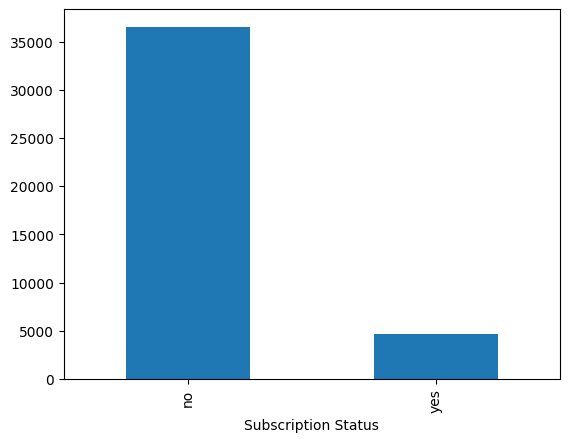

In [11]:
df['Subscription Status'].value_counts().plot(kind='bar')
df['Subscription Status'].value_counts()/df.shape[0]

### (2a) Column by Column Data Understanding & Insights

Data Understanding & Insights for Client ID\
From the description of Client ID, we can see that it is a unique identifier for each client.\
This indentifier column does not contain any missing values (41188 non-null values), which is equal to the total number of records in the dataset (41188).

In [12]:
display(df["Client ID"].nunique())
display(df["Client ID"].isna().sum())
display(df["Client ID"].describe())

41188

np.int64(0)

count    41188.00000
mean     20594.50000
std      11890.09578
min          1.00000
25%      10297.75000
50%      20594.50000
75%      30891.25000
max      41188.00000
Name: Client ID, dtype: float64

##### Data Understanding & Insights for Age
The "Age" feature in this dataset is stored as text, so it appears as an 'object' type.\
There are 77 unique ages\
The age "150 years" happens to appear in this dataset 4197 times, which is extremely unrealistic. The oldest person alive right now is 116 years old, which further solidifies the fact that there cannot be that many people who are significantly older.\
Hence, we will treat this value as an outlier\
The next oldest age after ""150 years" is "95 years", which is much more realistic.

In [13]:
display(df["Age"].dtype)
display(df["Age"].value_counts())

dtype('O')

Age
150 years    4197
31 years     1747
32 years     1646
33 years     1643
36 years     1606
             ... 
92 years        4
89 years        2
91 years        2
98 years        2
95 years        1
Name: count, Length: 77, dtype: int64

In [14]:
print("The number of unique ages is",df["Age"].nunique())

The number of unique ages is 77


In [15]:
display(df["Age"].value_counts().sort_index(ascending=False).head(10))
display(df["Age"].value_counts().sort_index(ascending=False).tail(10))

Age
98 years     2
95 years     1
92 years     4
91 years     2
89 years     2
88 years    19
86 years     8
85 years    15
84 years     7
83 years    16
Name: count, dtype: int64

Age
25 years      536
24 years      414
23 years      207
22 years      123
21 years       90
20 years       62
19 years       38
18 years       27
17 years        5
150 years    4197
Name: count, dtype: int64

##### Data Understanding & Insights for Occupation
This feature has a total of 12 different categories, with zero missing values.\
As this class is a categorial feature, we can use one-hot encoding.\
Later on during the bivariate analysis, we will be able to check how the different occupations can affect the subscription rates.

In [16]:
print("The number of occupations in this dataset is",df["Occupation"].nunique())
df["Occupation"].value_counts()

The number of occupations in this dataset is 12


Occupation
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

<class 'pandas.core.series.Series'>
RangeIndex: 41188 entries, 0 to 41187
Series name: Occupation
Non-Null Count  Dtype 
--------------  ----- 
41188 non-null  object
dtypes: object(1)
memory usage: 321.9+ KB


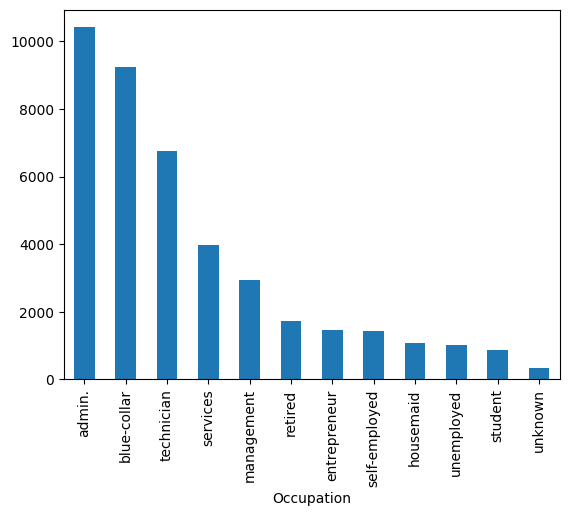

In [17]:
df['Occupation'].value_counts().plot(kind='bar')
df['Occupation'].info()
plt.show()

##### Data Understanding & Insights for Marital Status
This feature has a total of 4 different categories, with zero missing values.\
Similarly to the "Occupation" column, this class is a categorial feature, so we can use one-hot encoding.\
Later on during the bivariate analysis, we will be able to check how the different marital statuses can affect the subscription rates.\
It is particularly useful, as marital status can definitely influence financial decisions due to differing priorities and interests.

In [18]:
display(df["Marital Status"].value_counts())
display(df["Marital Status"].value_counts()/df.shape[0]*100)

Marital Status
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64

Marital Status
married     60.522482
single      28.085850
divorced    11.197436
unknown      0.194231
Name: count, dtype: float64

<class 'pandas.core.series.Series'>
RangeIndex: 41188 entries, 0 to 41187
Series name: Marital Status
Non-Null Count  Dtype 
--------------  ----- 
41188 non-null  object
dtypes: object(1)
memory usage: 321.9+ KB


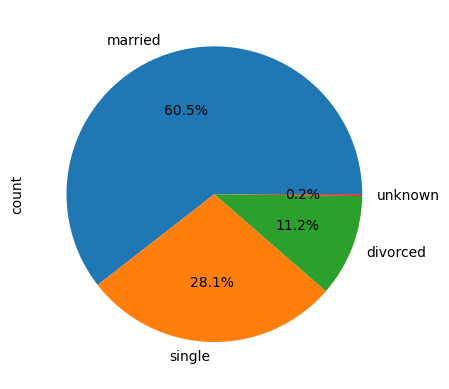

In [19]:
df['Marital Status'].value_counts().plot(kind='pie', autopct='%1.1f%%')
df['Marital Status'].info()
plt.show()

##### Data Understanding & Insights for Education Level
This feature has a total of 8 different categories, with zero missing values.\
This class is also a categorial feature, so we can use one-hot encoding.\
Later on during the bivariate analysis, we will be able to check how the different education levels can affect the subscription rates.\
Statistically, education generally correlates with income and financial literacy, which could affect the likelihood of individuals subscribing to the term deposit plan.

In [20]:
print("The number of different Education Levels in this dataset is",df["Education Level"].nunique())
df["Education Level"].value_counts()

The number of different Education Levels in this dataset is 8


Education Level
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

In [21]:
df[df["Education Level"]=="illeterate"]["Subscription Status"].head()

Series([], Name: Subscription Status, dtype: object)

<class 'pandas.core.series.Series'>
RangeIndex: 41188 entries, 0 to 41187
Series name: Education Level
Non-Null Count  Dtype 
--------------  ----- 
41188 non-null  object
dtypes: object(1)
memory usage: 321.9+ KB


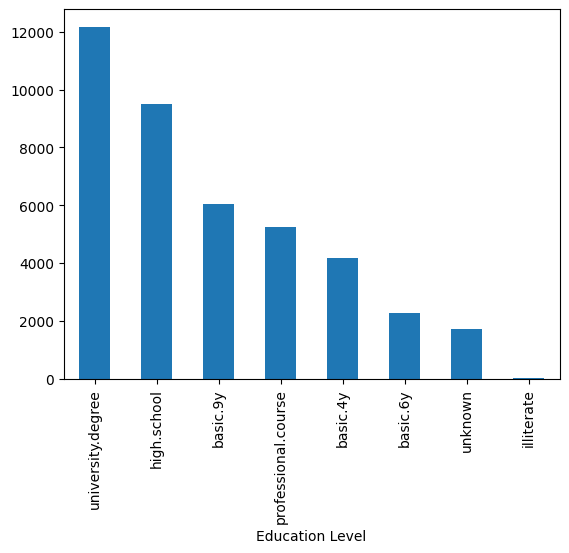

In [22]:
df['Education Level'].value_counts().plot(kind='bar')
df['Education Level'].info()
plt.show()

##### Data Understanding & Insights for Credit Default
This feature has a total of 3 different categories, with zero missing values. However there is a decently large number of the "unknown" class\
There is an extreme imbalance of data for this column, as seen below, where there are only three instances of "yes", which is 0.007% of the data.\
We will need to consider how we use the "yes" class later on, due to its scarcity.

In [23]:
display(df["Credit Default"].value_counts())
display(df["Credit Default"].value_counts()/df.shape[0]*100)

Credit Default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

Credit Default
no         79.120132
unknown    20.872584
yes         0.007284
Name: count, dtype: float64

##### Data Understanding & Insights for Housing Loan
This feature has a total of 3 different categories.\
There is a large number of null values for this column (24789), which is ~60% of the data.\
We will need to consider how we classify the null values later on, due to how much of the data it constitutes.

In [24]:
display(df["Housing Loan"].isna().sum())
display(df["Housing Loan"].isna().sum()/df.shape[0]*100)
display(df["Housing Loan"].value_counts())

np.int64(24789)

np.float64(60.18500534136157)

Housing Loan
yes        8595
no         7411
unknown     393
Name: count, dtype: int64

##### Data Understanding & Insights for Personal Loan
This feature has a total of 3 different categories.\
Similar to the previous column, Housing Loan, there are null values for this column (4146), which is ~10% of the data.\
This feature will be useful as having personal loan(s) could indicate that the person already has financial commitments and this could reduce the likeliness of them subscribing to a new term deposit.
We will need to consider how we classify the null values later on.

np.int64(4146)

np.float64(10.066038652034573)

Personal Loan
no         30532
yes         5633
unknown      877
Name: count, dtype: int64

Personal Loan
no         74.128387
yes        13.676313
unknown     2.129261
Name: count, dtype: float64

<Axes: xlabel='Personal Loan'>

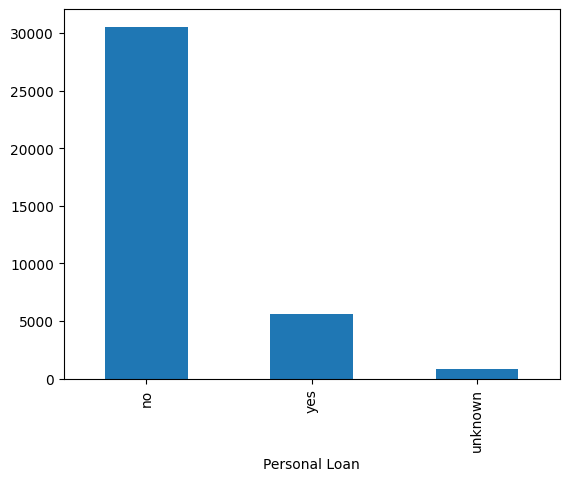

In [25]:
display(df["Personal Loan"].isna().sum())
display(df["Personal Loan"].isna().sum()/df.shape[0]*100)
display(df["Personal Loan"].value_counts())
display(df["Personal Loan"].value_counts()/df.shape[0]*100)
display(df["Personal Loan"].value_counts().plot(kind='bar'))

##### Data Understanding & Insights for Contact Method
This feature has a total of 4 different categories, with zero missing values.\
This class is also a categorial feature, so we can use one-hot encoding.\
However, it seems that the categories are inconsistent:\
-Cell & cellular\
-Telephone & telephone\
Before encoding, we will standardise the data by combining these into fewer categories as they have the same meanings.

<Axes: xlabel='Contact Method'>

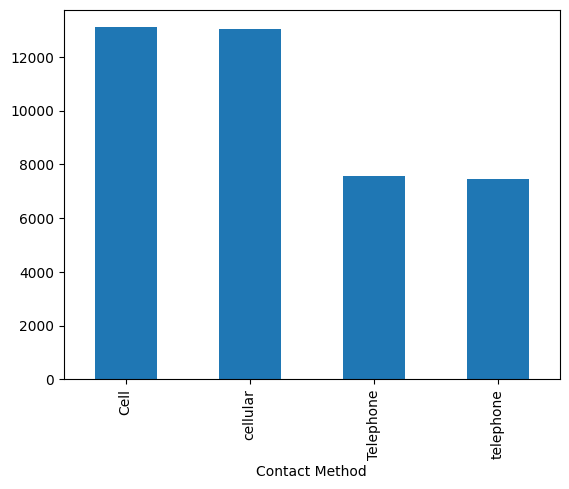

In [26]:
df["Contact Method"].value_counts()
df["Contact Method"].value_counts().plot(kind='bar')

##### Data Understanding & Insights for Campaign Calls
This feature has zero missing values.\
By looking at the output from the describe function, we can make some interesting insights:\
-The maximum value is 56 calls, meaning there are some outliers with heavy-contact\
-The minimum value is -41 calls, which is definitely an error as it is impossible to have negative calls\
\
Upon closer inspection, there are multiple values in this feature with a negative value.\
These invalid values need to be handled later by adjusting rows where the "Campaign Calls" is less than zero.

In [27]:
display(df["Campaign Calls"].value_counts())
display(df["Campaign Calls"].describe())

Campaign Calls
 1     15874
 2      9446
 3      4807
 4      2405
-1      1768
       ...  
 56        1
-41        1
 39        1
 37        1
-25        1
Name: count, Length: 70, dtype: int64

count    41188.000000
mean         2.051374
std          3.171345
min        -41.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: Campaign Calls, dtype: float64

In [28]:
display(df["Campaign Calls"].value_counts().sort_index(ascending=False).head(10))
display(df["Campaign Calls"].value_counts().sort_index(ascending=False).tail(10))

Campaign Calls
56    1
43    2
42    2
40    2
39    1
37    1
35    3
34    3
33    4
32    3
Name: count, dtype: int64

Campaign Calls
-20    3
-21    2
-22    3
-23    5
-25    1
-28    2
-29    1
-32    1
-35    2
-41    1
Name: count, dtype: int64

##### Data Understanding & Insights for Previous Contact Days
This feature has zero missing values.\
Majority of the values in this feature are "999"\
The project guide has stated that "999" means there has been no previous contact\
However leaving this as a numerical value of 999 will heavily skew and distort the actual statistics.\
Hence, we will create a different feature to address this later.

In [29]:
display(df["Previous Contact Days"].value_counts().sort_index(ascending=False).head(10))
display(df["Previous Contact Days"].value_counts().sort_index(ascending=False).tail(10))

Previous Contact Days
999    39673
27         1
26         1
25         1
22         3
21         2
20         1
19         3
18         7
17         8
Name: count, dtype: int64

Previous Contact Days
9     64
8     18
7     60
6    412
5     46
4    118
3    439
2     61
1     26
0     15
Name: count, dtype: int64

#### Further Insights for the distribuiton of Subscription Status

Looking further into this feature, we can see that the no to yes ratio nearly reaches a 9:1.\
This shows that this dataset is heavily imbalanced and skewed.\
When training our models during the pipeline, we definitely take some factors into consideration, such as:\
-Proper sampling\
-Approriate metrics\
-Assigning weights to the data

In [30]:
df["Subscription Status"].value_counts()
percentage_wise=df["Subscription Status"].value_counts()/df.shape[0]*100
print(percentage_wise)

Subscription Status
no     88.734583
yes    11.265417
Name: count, dtype: float64


### (3) Handling the null values / incorrect values / outliers 

In order to convert the string inside the "Age" column into integer values, we must do the following:

In [31]:
df["Age_numerical"]=(df["Age"].str.replace('years', '', regex=False).astype('int'))

For this next part, we addressed the outlier age of "150", by imputing the value using the median age. Firstly, we care commonly taught to drop the values if it is 5% of the total number of observations. However the total number of instances where the age is equal to 150 is ~10%, hence we decided on using imputation of values. Next we had to choose between median and mean imputation. Median imputation was chosen as the ages goes all the way up to 98 and median is more stable than mean, as it will not skew the cleaned dataset as much.

In [32]:
df_150=df[df["Age"]=="150 years"]
print(df_150.head(50))

     Client ID        Age     Occupation Marital Status      Education Level  \
7        23758  150 years         admin.       divorced    university.degree   
13       21872  150 years         admin.        married    university.degree   
17       17689  150 years     technician        married  professional.course   
51       38203  150 years        retired        married          high.school   
59       29732  150 years    blue-collar        married             basic.4y   
61        4501  150 years         admin.         single    university.degree   
67        1632  150 years         admin.        married          high.school   
73       35637  150 years       services         single          high.school   
77       24445  150 years         admin.         single          high.school   
82        4244  150 years    blue-collar        married             basic.4y   
83       13927  150 years       services         single          high.school   
89        8086  150 years    blue-collar

In [33]:
df["Age_Invalid"] = (df["Age_numerical"] == 150).astype('int')
valid_median_age=df.loc[df["Age_numerical"]!=150,"Age_numerical"].median()
df.loc[df["Age_numerical"]==150,"Age_numerical"]= valid_median_age
#df=df.drop(columns=["Age"])
df["Age_numerical"].describe()

count    41188.000000
mean        39.818928
std          9.909692
min         17.000000
25%         33.000000
50%         38.000000
75%         46.000000
max         98.000000
Name: Age_numerical, dtype: float64

For the next few columns:\
-Occupation\
-Marital Status\
\
We decided to leave these columns as it is. There are no missing values from these columns, and although there is an "uknown" value inside these columns, they are still valuable insights and will be kept.

#### This is because these features will affect the client and whether or not they will subscribe to the term deposit, and I will give my reasonings below:
Occupation: Different jobs and careers, will affect the amount of money said client is currently making. For example, a person working in a management job is generally going to earn more than person working in a blue-collar job. Hence, for the person working in management, this can influence their financial decisions as having a higher discretionary income means that there is more savings and can be put towards other activities. However, for the person working a blue-collar job, they might have a lower discretionary income and hence subscribing to a term deposit might not be a consideration for them as it is lower on their priority list, or they might not have the disposable income to do so.\
\
Marital Status: As I have said earlier during the initial understandings, marital status can definitely influence financial decisions due to differing priorities and interests. For example, if the client is married, there is a higher chance that they would be paying for their mortgage or saving money towards retirement or even their children's education. Hence it is still an important feature.\



#### Handling of unknown values in the "Education Level" Column
When inspecting the "Education Level" column, we can see that there are multiple different categories: university degree, high school, basic (4 years), basic (6 years), basic (9 years), professional course, unknown and illiterate.\
A major thing we took note of was the uneven distribution of clients in the different categories for this column, and further inspection into the unknown and illiterate categories show that they total to less than 5% of the total data.\
Although it is a good choice to have the "unknown" and "illiterate" columns,  they face an extreme class imbalance. There are only a total of 1749 instances of these columns having data, and this is out of a total of 41188. This means that it only constitutes to around 4.25%, which is quite low. Hence, these 2 categories would not affect training or evaluation of predictive models as it does not provide much meaning or value to prediction. These categories also cannot be merged with any other column, as they are each unique and have completely different meanings. Hence, we decided to exclude these 2 categories from the final cleaned dataset. This will be applied to the training of the selected models to prevent overfitting, as keeping these features would cause instability besides from not contributing any predictive value.

In [34]:
display(df["Education Level"].value_counts())
display(df["Education Level"].unique())

Education Level
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

array(['high.school', 'unknown', 'basic.9y', 'professional.course',
       'university.degree', 'basic.4y', 'basic.6y', 'illiterate'],
      dtype=object)

In [35]:
df=df[df["Education Level"]!="illiterate"]
df=df[df["Education Level"]!="unknown"]

In [36]:
df["Education Level"].value_counts()

Education Level
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
Name: count, dtype: int64

#### Handling of the "Credit  Default" Features
When inspecting the "Credit Default" column, we can see that there are 3 different categories, "yes", "no" and "unknown"\
No credit default can indicate that the client has financial stability and is more responisble with their money, which can affect their decision on whether they should or should not subscribe. The "unknown" class in this data indicate that the client has not have borrowed money from this bank before or the record could be incomplete. "Yes" in the context of credit default means that they did not manage to make the payments on time, and could signify that the person is tight on money. Although it is a good choice to have the "Yes" column,  it faces an extreme class imbalance. There are only 3 instances of this being positive, and this is out of a total of 41188. This means that it only constitutes to around 0.00728%, which is extremely low. Hence, the "Yes" category would not affect training or evaluation of predictive models as it does not provide any meaning or value towards predictions. This category also cannot be merged with "unknown", as they have completely different meanings. Hence, we decided to exclude this category from the final cleaned dataset. This will be applied to the training of the selected models to prevent overfitting, as keeping this feature would cause instability besides from not contributing any predictive value.

In [37]:
df["Credit Default"].value_counts()

Credit Default
no         31394
unknown     8042
yes            3
Name: count, dtype: int64

In [38]:
df=df[df["Credit Default"]!="yes"]
df["Credit Default"].value_counts()

Credit Default
no         31394
unknown     8042
Name: count, dtype: int64

Before moving on to the next features, we wanted to visualize and confirm that the next two rows we would be working on do indeed have null values.

In [39]:
import missingno as msno

<Axes: >

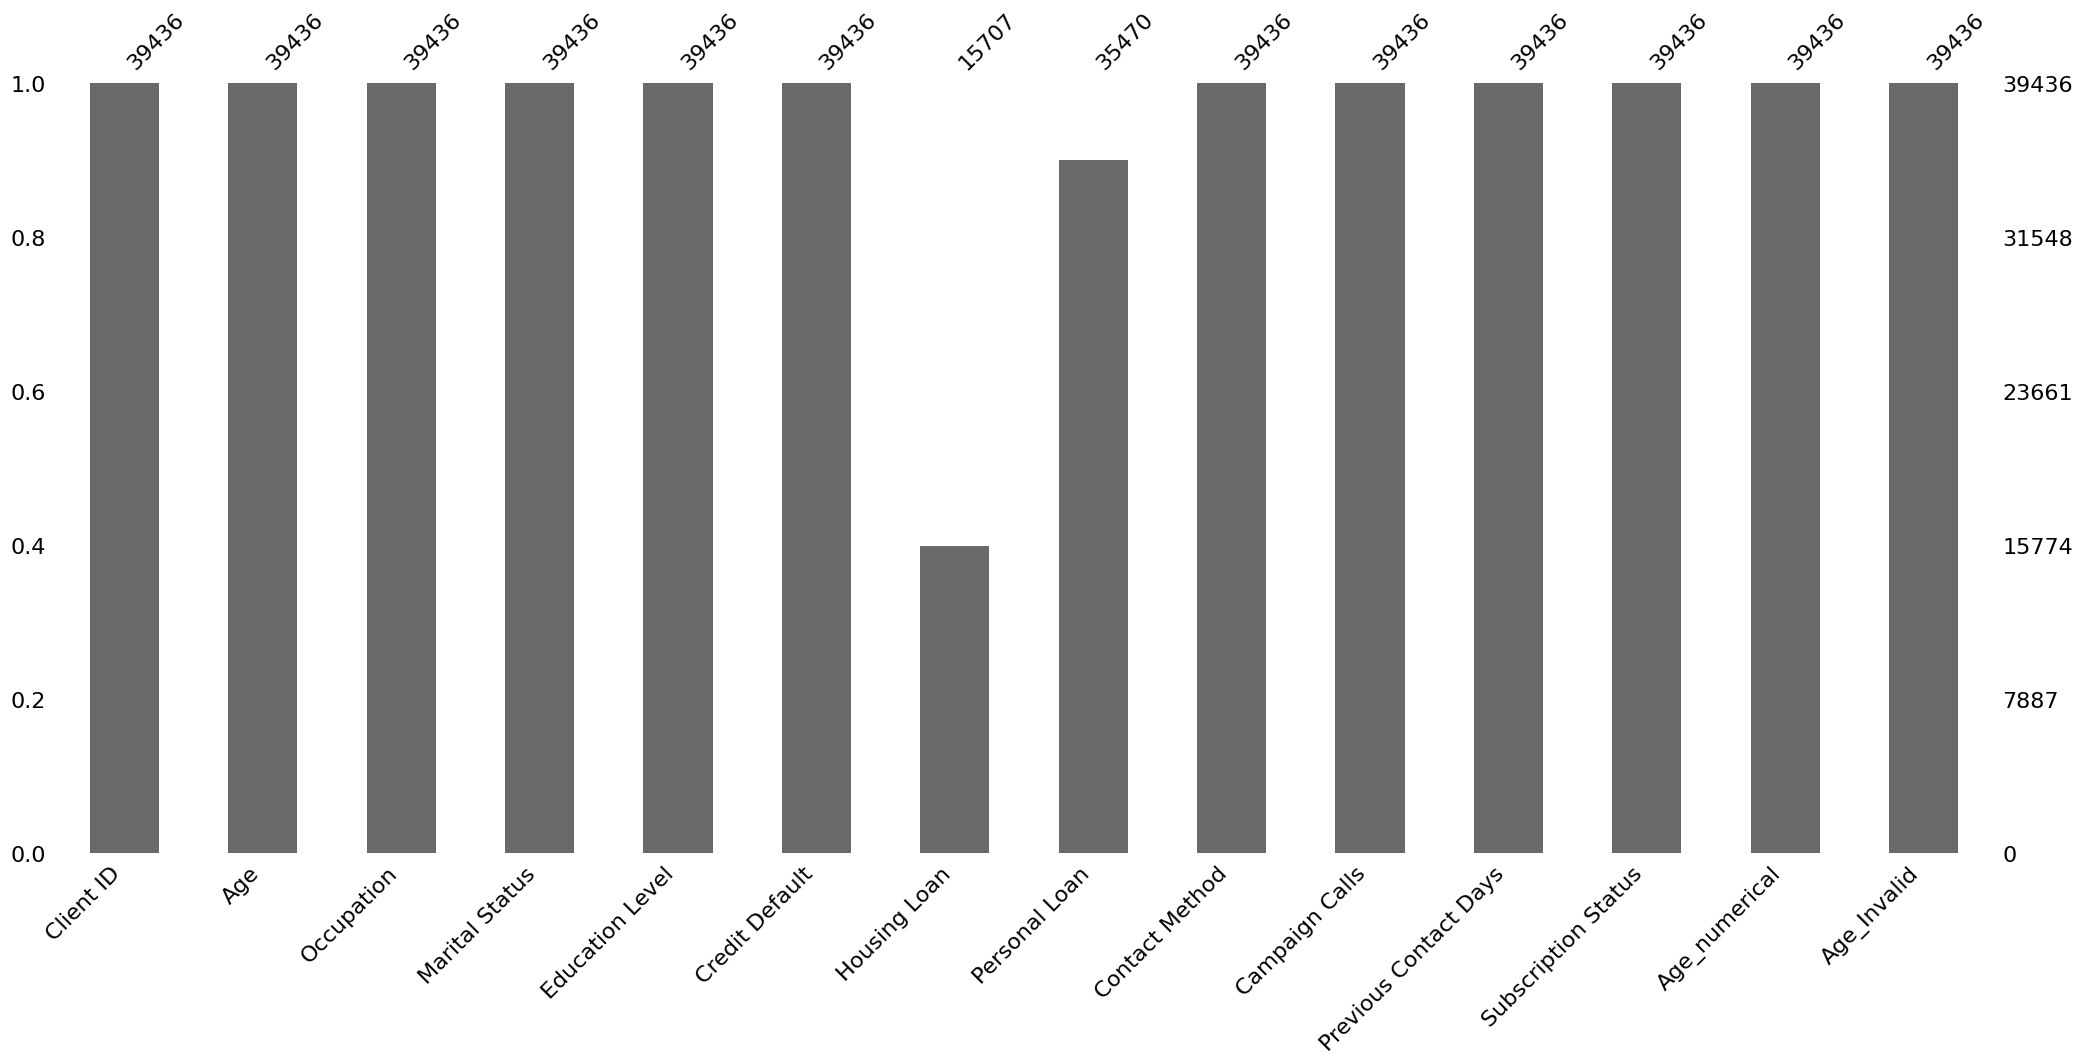

In [40]:
msno.bar(df)

In [41]:
pd.options.display.max_rows = 999
nulls = df.isna().sum().sort_values(ascending=False)
nulls[nulls>0]

Housing Loan     23729
Personal Loan     3966
dtype: int64

In [42]:
df.shape

(39436, 14)

#### Cleaning of the "Housing Loan" Feature
When inspecting the "Housing Loan" column, we can see that there are 3 different categories, "yes", "no", "unknown" and the null values appear as as "None".\
However, "None" and "no" do not mean the same thing in this case. "no" most likely refers to the client not having any housing loans, while "None" means that the bank has never recorded down the status of the client's housing loans, hence we are not able to verify whether they have or do not have any housing loans.\
We have decided to leave unknown here alone even though it constitutes to a very small minority of the data as our models can assign weights to handle this category.\
We will fill the "None" values with "no_info" to standardize. This creates a total of 4 categories

In [43]:
df[df["Housing Loan"].isna()].head(15)

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Age_numerical,Age_Invalid
4,14021,27 years,housemaid,married,high.school,no,None,no,Cell,2,999,no,27,0
5,17202,58 years,retired,married,professional.course,no,None,yes,Cell,1,999,no,58,0
8,10822,24 years,entrepreneur,married,university.degree,no,None,None,telephone,4,999,no,24,0
10,32312,34 years,blue-collar,married,basic.9y,no,None,no,Cell,3,999,no,34,0
12,13596,43 years,blue-collar,single,basic.9y,no,None,no,cellular,1,999,yes,43,0
14,16736,58 years,blue-collar,married,basic.4y,no,None,yes,cellular,3,999,no,58,0
17,17689,150 years,technician,married,professional.course,no,None,yes,cellular,-11,999,no,38,1
18,15508,37 years,entrepreneur,single,professional.course,no,None,no,cellular,2,999,no,37,0
20,17268,59 years,retired,married,basic.9y,unknown,None,no,cellular,3,999,yes,59,0
21,1671,49 years,unemployed,single,professional.course,unknown,None,no,telephone,2,999,no,49,0


In [44]:
df[df["Housing Loan"]=="no"].head(15)

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Age_numerical,Age_Invalid
0,32885,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no,57,0
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no,33,0
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no,36,0
13,21872,150 years,admin.,married,university.degree,no,no,no,Cell,3,999,yes,38,1
24,20771,51 years,management,married,high.school,unknown,no,no,Cell,1,999,no,51,0
31,36563,69 years,entrepreneur,married,high.school,no,no,no,cellular,2,999,yes,69,0
38,8726,30 years,blue-collar,married,basic.6y,no,no,no,telephone,2,999,no,30,0
39,25810,30 years,management,married,university.degree,no,no,no,Cell,5,999,no,30,0
64,40577,33 years,technician,single,professional.course,no,no,no,Cell,1,999,no,33,0
70,18429,47 years,admin.,married,high.school,unknown,no,yes,Telephone,-5,999,no,47,0


In [45]:
df[df["Housing Loan"]=="unknown"].head(15)

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Age_numerical,Age_Invalid
169,36548,50 years,admin.,single,basic.9y,no,unknown,unknown,Cell,1,999,yes,50,0
211,14241,27 years,blue-collar,single,basic.9y,no,unknown,unknown,Cell,3,999,no,27,0
244,14423,32 years,admin.,single,university.degree,no,unknown,unknown,Cell,3,999,no,32,0
401,31694,38 years,technician,married,university.degree,no,unknown,unknown,Cell,-1,999,no,38,0
404,6661,54 years,admin.,married,high.school,no,unknown,unknown,telephone,1,999,no,54,0
468,9332,40 years,admin.,married,university.degree,unknown,unknown,unknown,telephone,6,999,no,40,0
804,15179,29 years,unemployed,married,university.degree,no,unknown,unknown,cellular,2,999,no,29,0
860,26664,34 years,unemployed,married,high.school,no,unknown,unknown,Cell,2,999,no,34,0
906,19859,49 years,technician,married,professional.course,unknown,unknown,unknown,Cell,2,999,no,49,0
952,20069,43 years,admin.,married,university.degree,no,unknown,unknown,cellular,2,999,no,43,0


In [46]:
df["Housing Loan"]=df["Housing Loan"].fillna("no_info")
display(df["Housing Loan"].isna().value_counts())
display(df["Housing Loan"].value_counts())

Housing Loan
False    39436
Name: count, dtype: int64

Housing Loan
no_info    23729
yes         8242
no          7087
unknown      378
Name: count, dtype: int64

Similar to the "Housing Loan" column, there are 3 different categories, "yes", "no", "unknown" and null values as "None".\
However, "None" and "no" do not mean the same thing in this case. "no" most likely refers to the client not having any personal loans, while "None" means that the bank has never recorded down the status of the client's personal loans, hence we are not able to verify whether they have or do not have any personal loans.\
We have decided to leave unknown here alone even though it constitutes to a very small minority of the data as our models can assign weights to handle this category.\
We will fill the "None" values with "no_info" to standardize.

In [47]:
display(df[df["Personal Loan"].isna()].head(5))
display(df[df["Personal Loan"]=="no"].head(5))
df[df["Personal Loan"]=="unknown"].head(5)

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Age_numerical,Age_Invalid
7,23758,150 years,admin.,divorced,university.degree,unknown,yes,None,Cell,7,999,no,38,1
8,10822,24 years,entrepreneur,married,university.degree,no,no_info,None,telephone,4,999,no,24,0
58,39197,41 years,admin.,divorced,university.degree,no,yes,None,Cell,2,6,yes,41,0
63,3420,45 years,blue-collar,married,basic.4y,no,no_info,None,Telephone,3,999,no,45,0
80,33318,41 years,management,married,high.school,unknown,yes,None,Cell,2,999,no,41,0


,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Age_numerical,Age_Invalid
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no,33,0
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no,36,0
4,14021,27 years,housemaid,married,high.school,no,no_info,no,Cell,2,999,no,27,0
6,880,48 years,services,married,high.school,unknown,yes,no,Telephone,1,999,no,48,0
10,32312,34 years,blue-collar,married,basic.9y,no,no_info,no,Cell,3,999,no,34,0


,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Age_numerical,Age_Invalid
164,13416,150 years,technician,married,university.degree,no,no_info,unknown,Telephone,1,999,no,38,1
169,36548,50 years,admin.,single,basic.9y,no,unknown,unknown,Cell,1,999,yes,50,0
188,8815,30 years,technician,single,professional.course,no,no_info,unknown,telephone,1,999,no,30,0
211,14241,27 years,blue-collar,single,basic.9y,no,unknown,unknown,Cell,3,999,no,27,0
212,24204,150 years,unemployed,married,university.degree,no,no_info,unknown,Cell,1,999,no,38,1


In [48]:
display(df["Personal Loan"].isna().sum())
df["Personal Loan"]=df["Personal Loan"].fillna("no_info")
display(df["Personal Loan"].isna().value_counts())
display(df["Personal Loan"].value_counts())

np.int64(3966)

Personal Loan
False    39436
Name: count, dtype: int64

Personal Loan
no         29218
yes         5409
no_info     3966
unknown      843
Name: count, dtype: int64

#### Cleaning of the "Contact Method" Feature
When inspecting the "Contact Method" column, we can see that there are 4 different categories, "Cell", "cellular", "Telephone" and "telephone".\
To clean this, we will convert them into similar, lowercase terms:\
"Telephone" & "telephone" --> "telephone"\
"Cell" & "cellular" --> "cellular"

In [49]:
df["Contact Method"].value_counts()

Contact Method
Cell         12574
cellular     12535
Telephone     7189
telephone     7138
Name: count, dtype: int64

In [50]:
df["Contact Method"]= df["Contact Method"].replace({"Cell":"cellular", "Telephone":"telephone"})
df["Contact Method"].value_counts()

Contact Method
cellular     25109
telephone    14327
Name: count, dtype: int64

#### Cleaning of the "Campaign Calls" Feature
When inspecting the "Campaign" column, we can see that there are many values that are negative.\
To clean this, we must first check the number of negative values, before we make a decision.

In [51]:
df[df["Campaign Calls"]<0].shape[0]

3967

After looking at the values, ~10% of the data is less than 0, so it is not wise to drop these rows.\
Instead, we decided to impute the values, similar to what we did for the cleaing of the "Age" column.\


In [52]:
df["Calls_Invalid"] = (df["Campaign Calls"] <0).astype(int)
valid_median_calls=df.loc[df["Campaign Calls"]>=0,"Campaign Calls"].median()
df.loc[df["Campaign Calls"]<0,"Campaign Calls"]= valid_median_calls
display(df["Campaign Calls"].describe())
display(df["Calls_Invalid"].value_counts())

count    39436.000000
mean         2.509433
std          2.627374
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: Campaign Calls, dtype: float64

Calls_Invalid
0    35469
1     3967
Name: count, dtype: int64

#### Cleaning of the "Previous Contact Days" Feature
As seen in the project guide, values like "999" are placeholders for "No previous contact".\
Hence, we cannot treat this as a numeric value, or it will skew the other data.\
We decided to replace 999 with NaN and create a new column with binary features to show whether there has been contact or not, using "1" and "0".\
This helps to remove any instances which could heavily imbalance our data, and still preserve the knowledge of knowing which clients have had contact or no previous contact.\
Keeping this information is extremely important for our project, as it can influence a person's decision.

In [53]:
df["no_previous_contact"] = (df["Previous Contact Days"] == 999)
df["no_previous_contact"]=df["no_previous_contact"].astype(int)
df["Previous Contact Days_clean"]= df["Previous Contact Days"].replace(999, np.nan)

In [54]:
display(df["Previous Contact Days"].head())
display(df["no_previous_contact"].head())
display(df["Previous Contact Days_clean"].head())

0    999
2    999
3    999
4    999
5    999
Name: Previous Contact Days, dtype: int64

0    1
2    1
3    1
4    1
5    1
Name: no_previous_contact, dtype: int64

0   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: Previous Contact Days_clean, dtype: float64

In [55]:
df.head()

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Age_numerical,Age_Invalid,Calls_Invalid,no_previous_contact,Previous Contact Days_clean
0,32885,57 years,technician,married,high.school,no,no,yes,cellular,1,999,no,57,0,0,1,NaN
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no,33,0,0,1,NaN
3,9404,36 years,admin.,married,high.school,no,no,no,telephone,4,999,no,36,0,0,1,NaN
4,14021,27 years,housemaid,married,high.school,no,no_info,no,cellular,2,999,no,27,0,0,1,NaN
5,17202,58 years,retired,married,professional.course,no,no_info,yes,cellular,1,999,no,58,0,0,1,NaN


In [56]:
df=df.reset_index(drop=True)

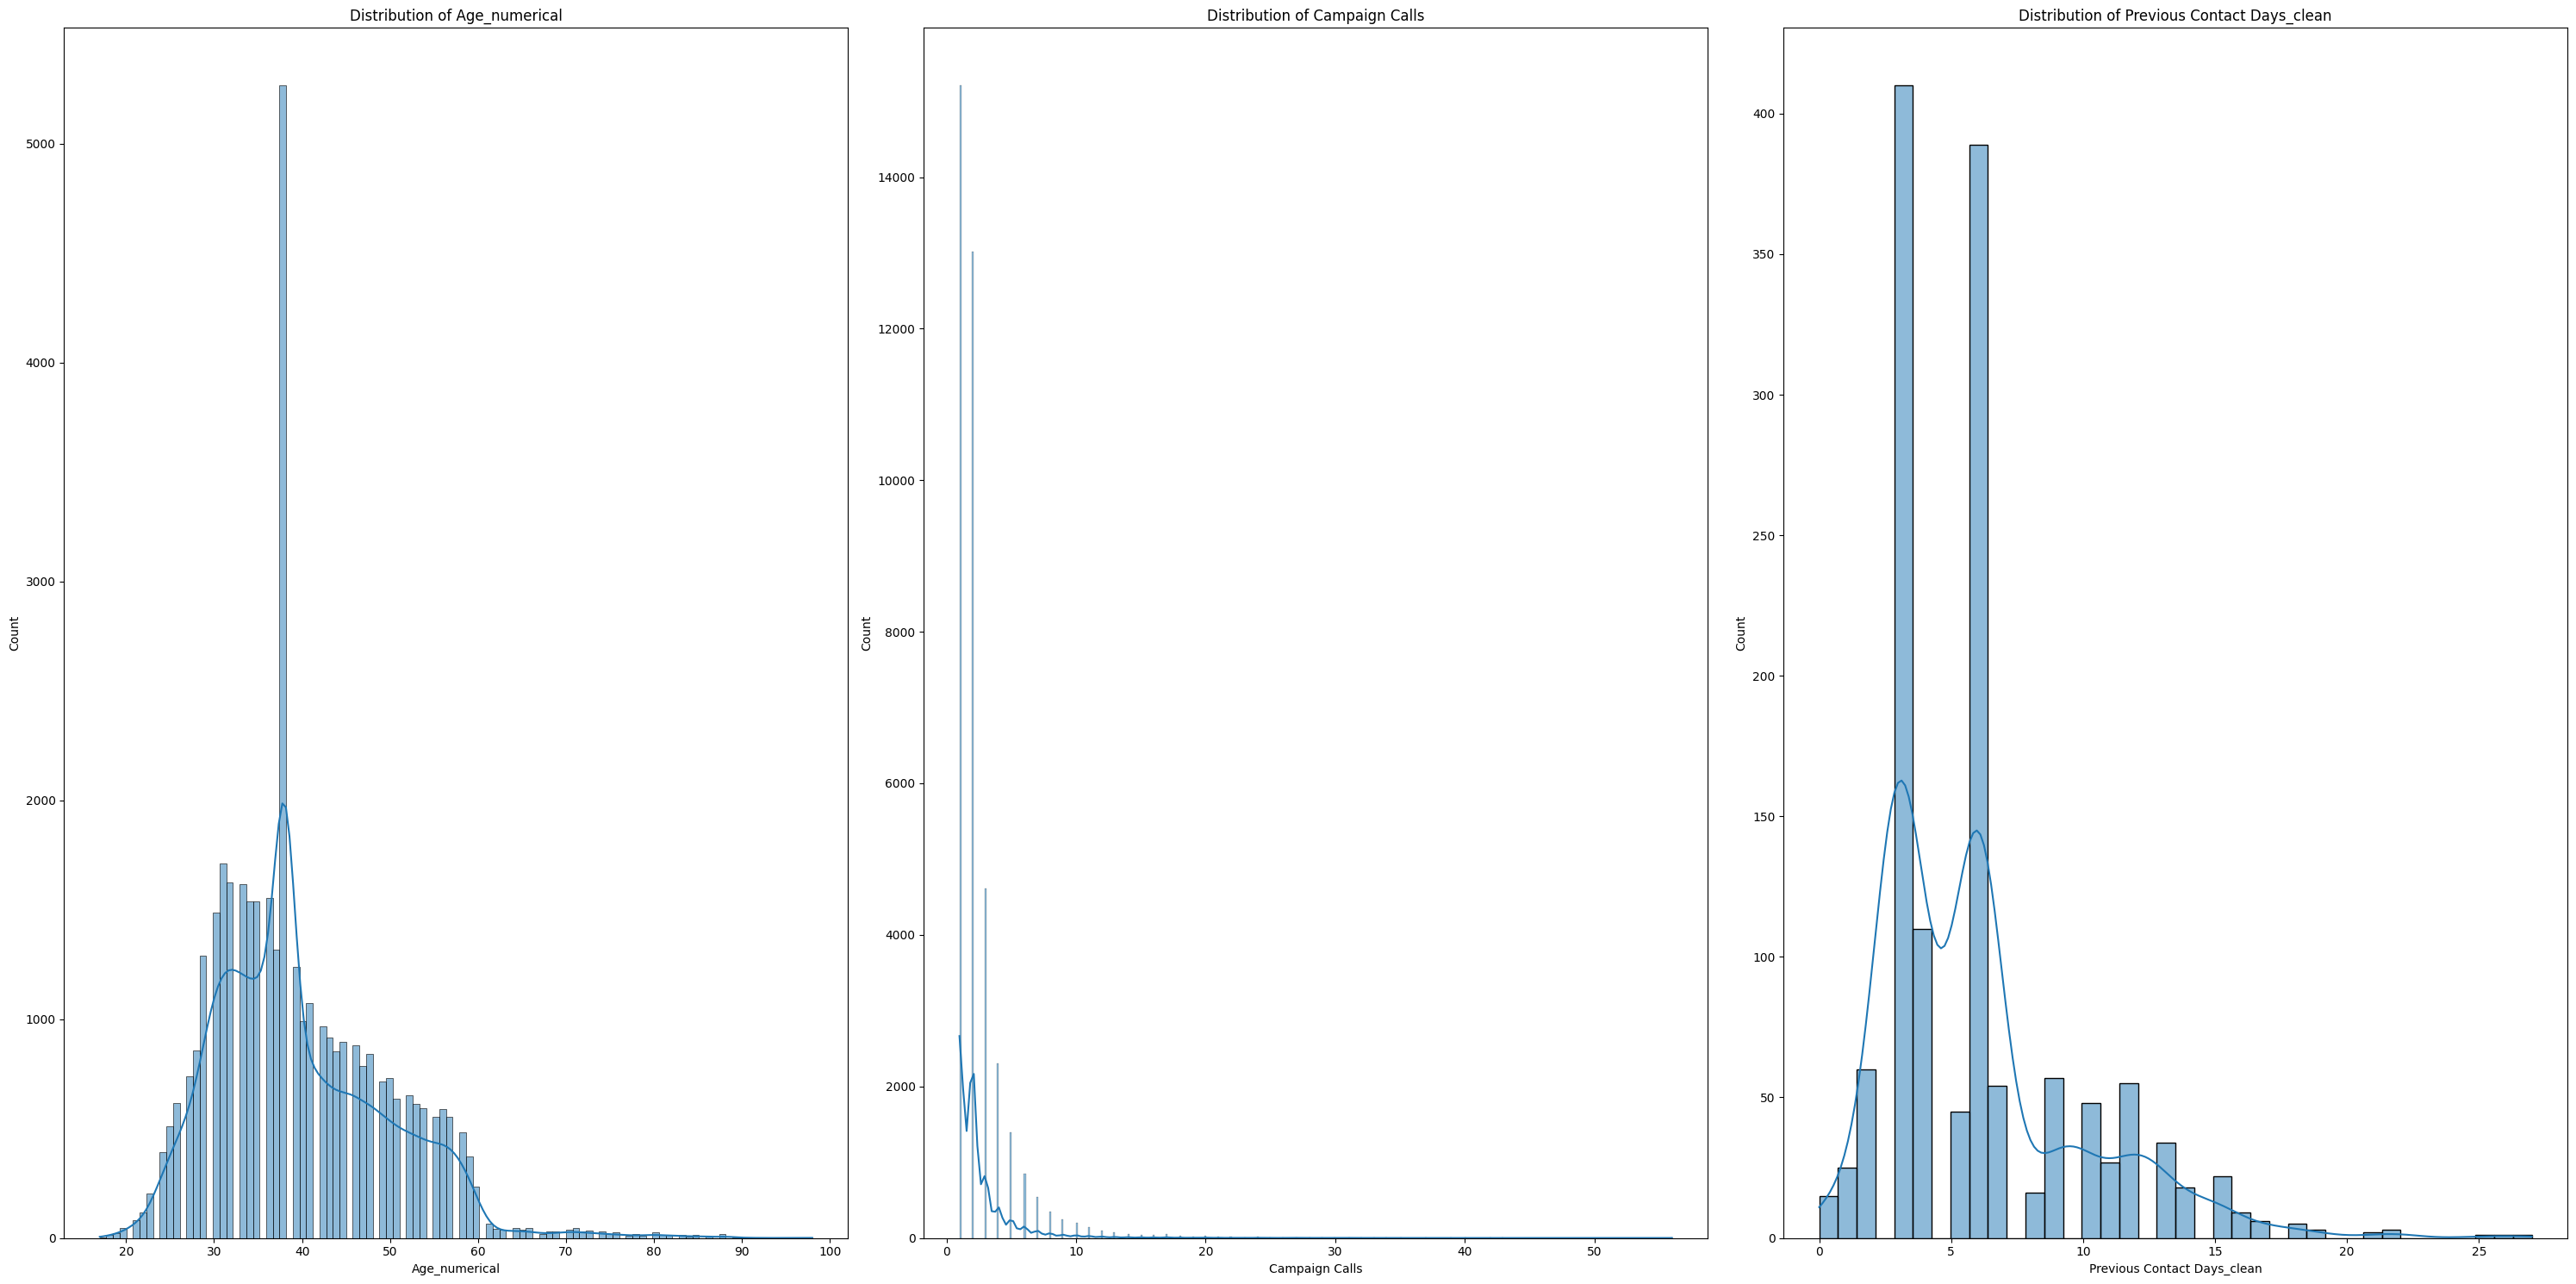

In [57]:
num_cols = ["Age_numerical", "Campaign Calls", "Previous Contact Days_clean"]

plt.figure(figsize=(30,15))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### (4) Bivariate Analysis

Our main target variable for this EDA is "Subscription Status". However It is currently categorical (yes/no)\
In order to conduct this bivariate analysis, we first have to encode it into numeric characters in order for this to work.\
The following changes will be made:\
"1"-> subscribed ("yes")\
"0"-> not subscribed ("no")

In [58]:
df["Subscription_Status_Code"]=df["Subscription Status"].map({"yes":1, "no":0})
df["Subscription_Status_Code"].value_counts()

Subscription_Status_Code
0    35051
1     4385
Name: count, dtype: int64

In [59]:
df_cleaned = df.drop(columns=["Age", "Previous Contact Days"])

In [60]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39436 entries, 0 to 39435
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Client ID                    39436 non-null  int64  
 1   Occupation                   39436 non-null  object 
 2   Marital Status               39436 non-null  object 
 3   Education Level              39436 non-null  object 
 4   Credit Default               39436 non-null  object 
 5   Housing Loan                 39436 non-null  object 
 6   Personal Loan                39436 non-null  object 
 7   Contact Method               39436 non-null  object 
 8   Campaign Calls               39436 non-null  int64  
 9   Subscription Status          39436 non-null  object 
 10  Age_numerical                39436 non-null  int64  
 11  Age_Invalid                  39436 non-null  int64  
 12  Calls_Invalid                39436 non-null  int64  
 13  no_previous_cont

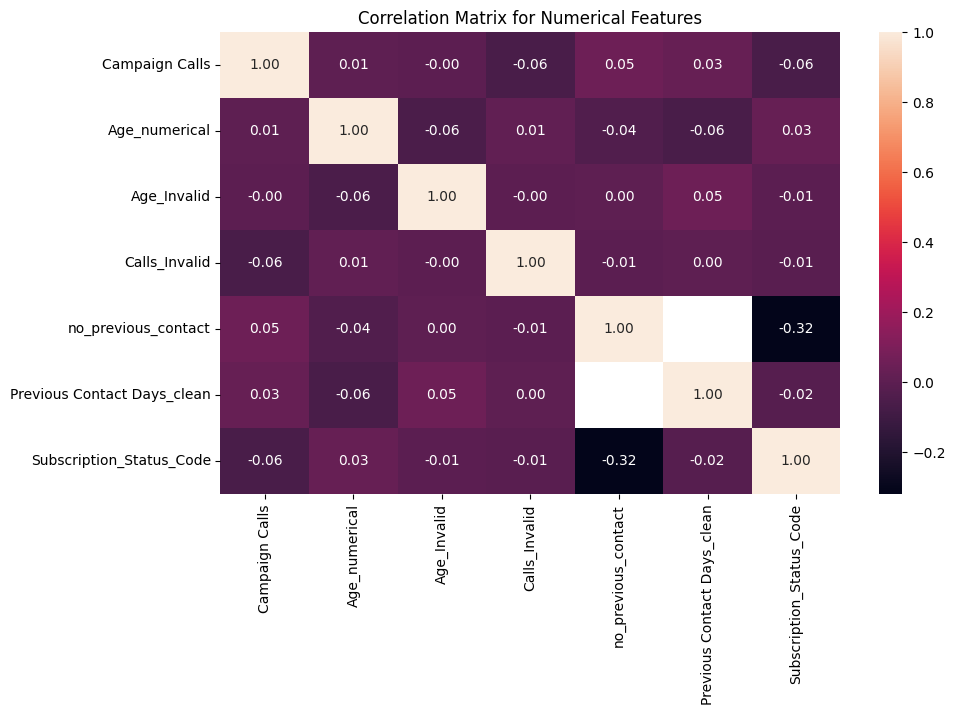

In [61]:
plt.figure(figsize=(10,6))
num_cols= ["Campaign Calls", "Age_numerical", "Age_Invalid", "Calls_Invalid", "no_previous_contact", "Previous Contact Days_clean", "Subscription_Status_Code"]
df_numerical_relationship=df_cleaned[num_cols]
sns.heatmap(df_numerical_relationship.corr(numeric_only=True), annot=True, fmt=".2f")
plt.title("Correlation Matrix for Numerical Features")
plt.show()

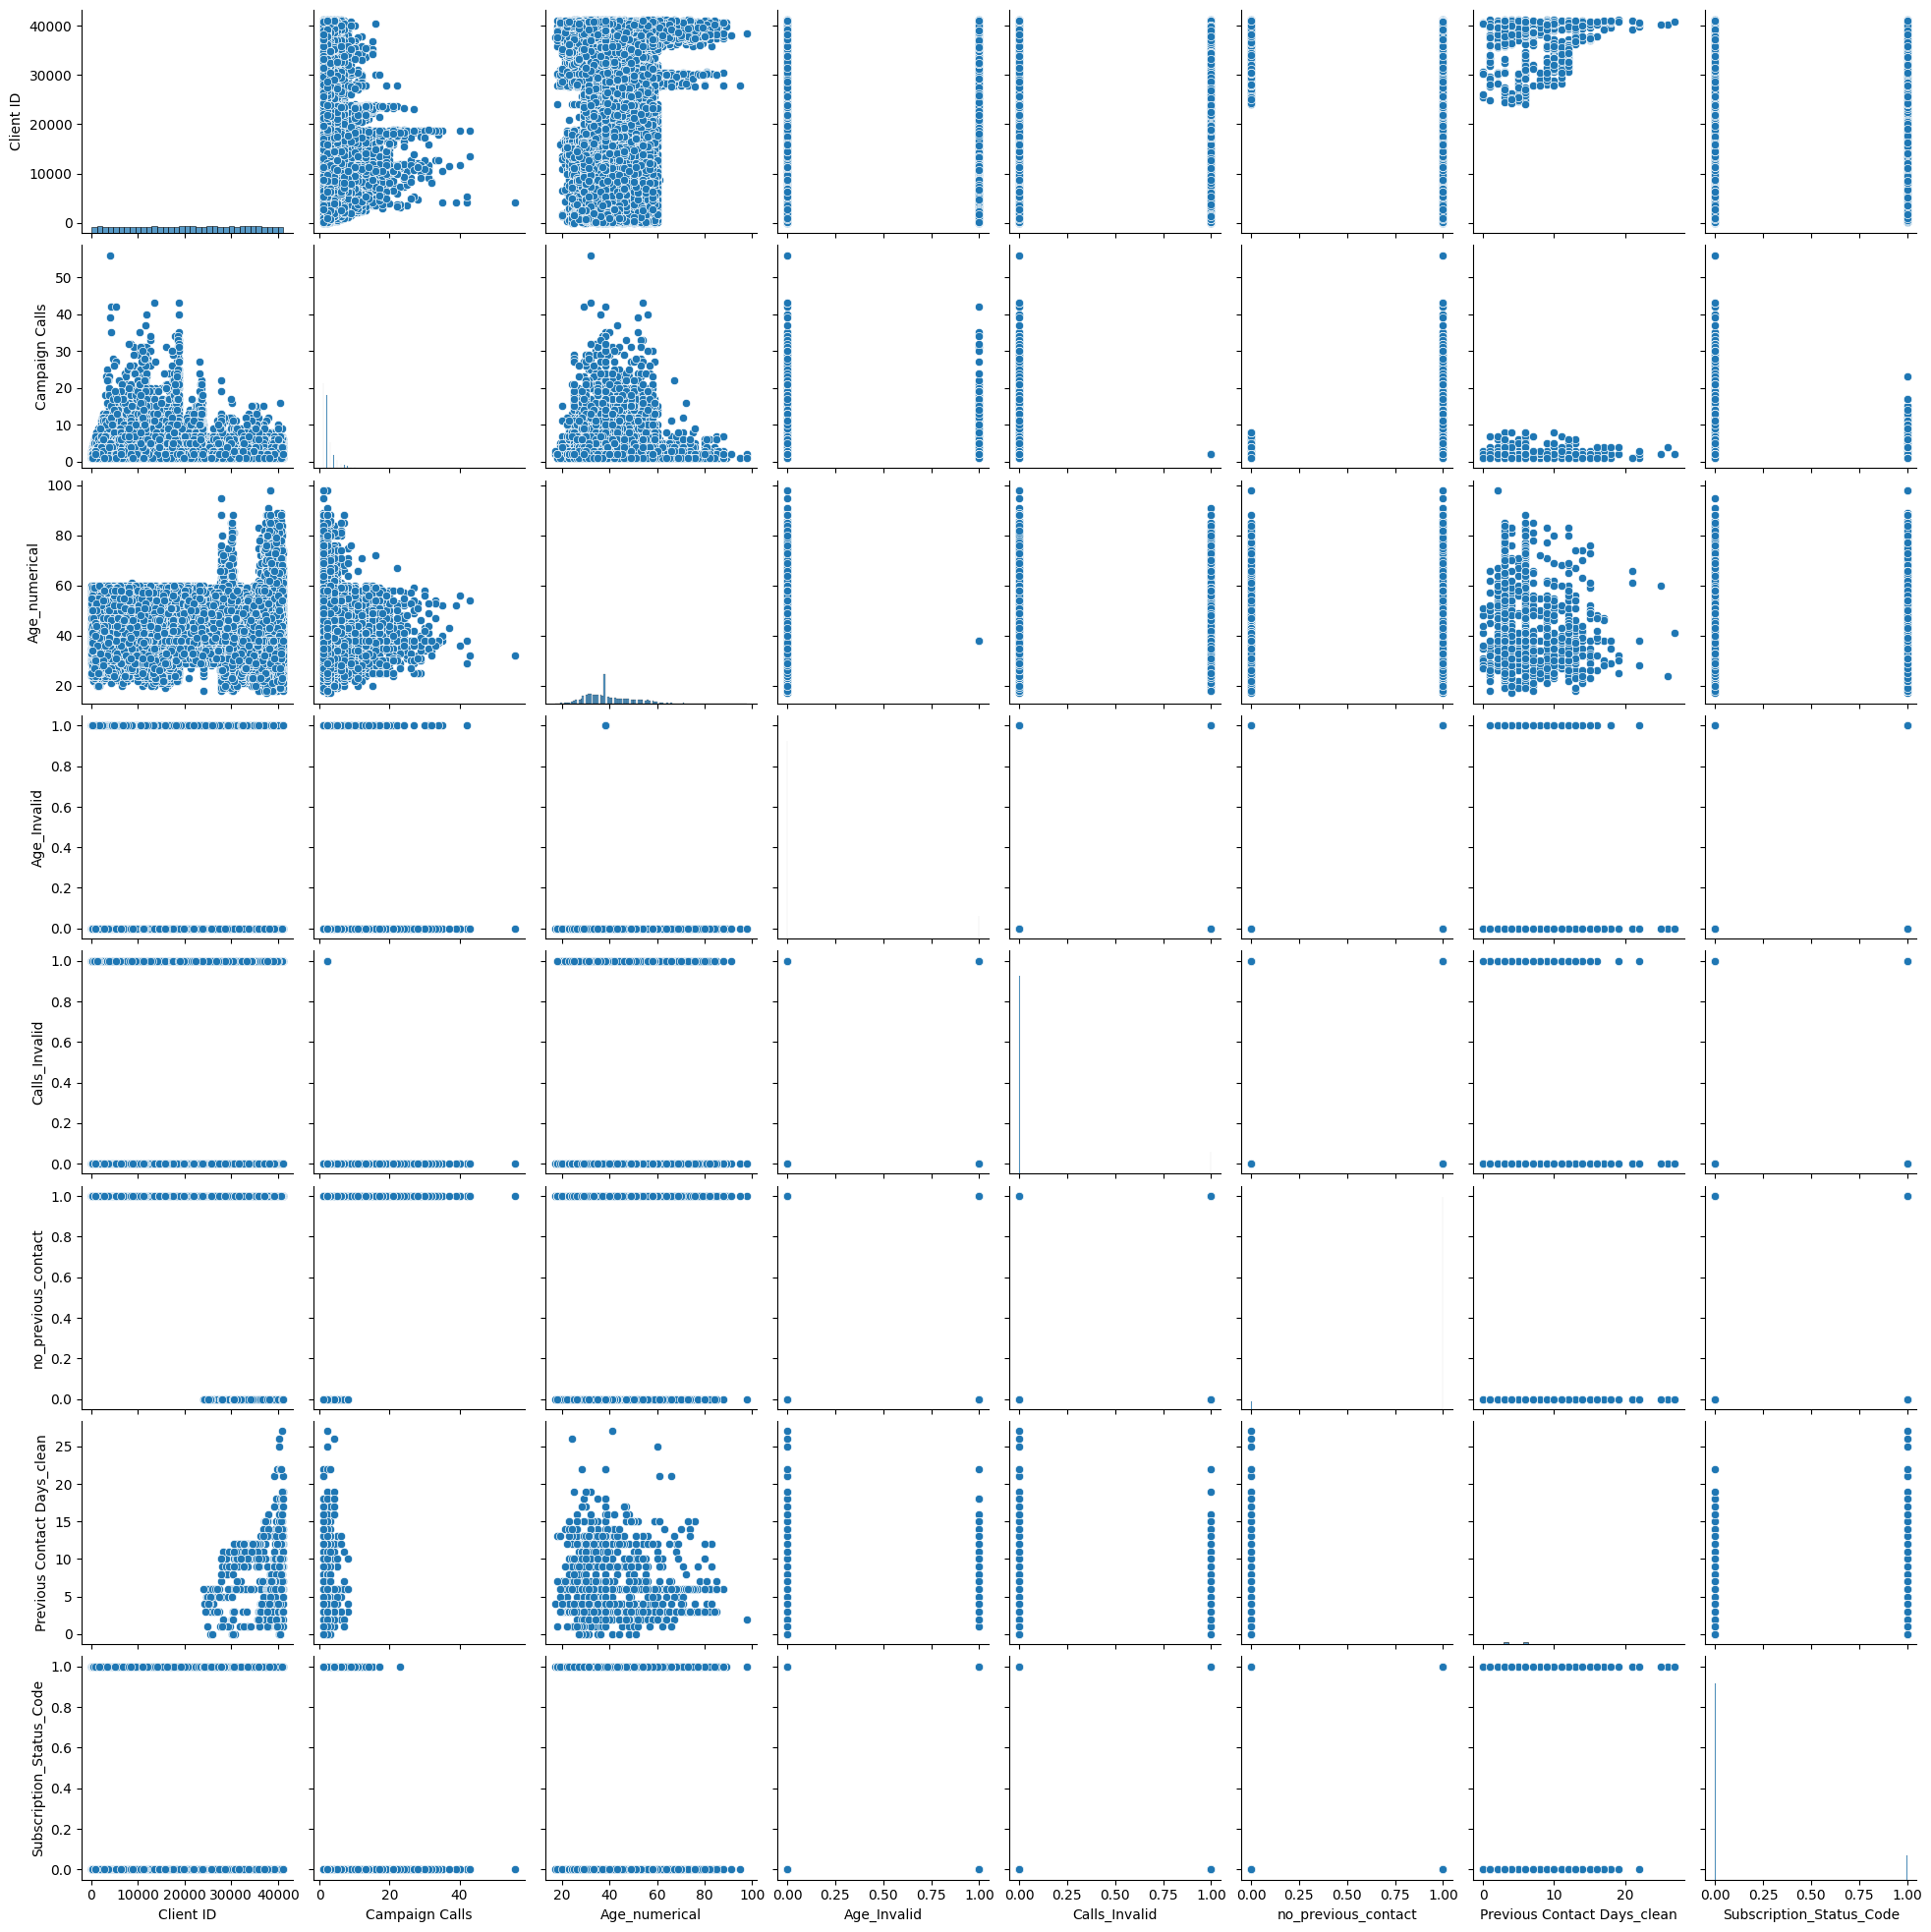

In [62]:
sns.pairplot(df_cleaned)

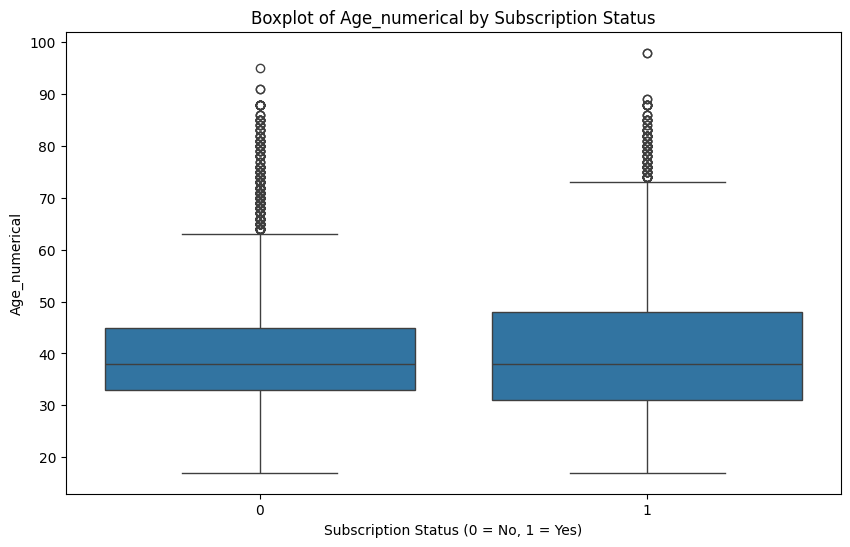

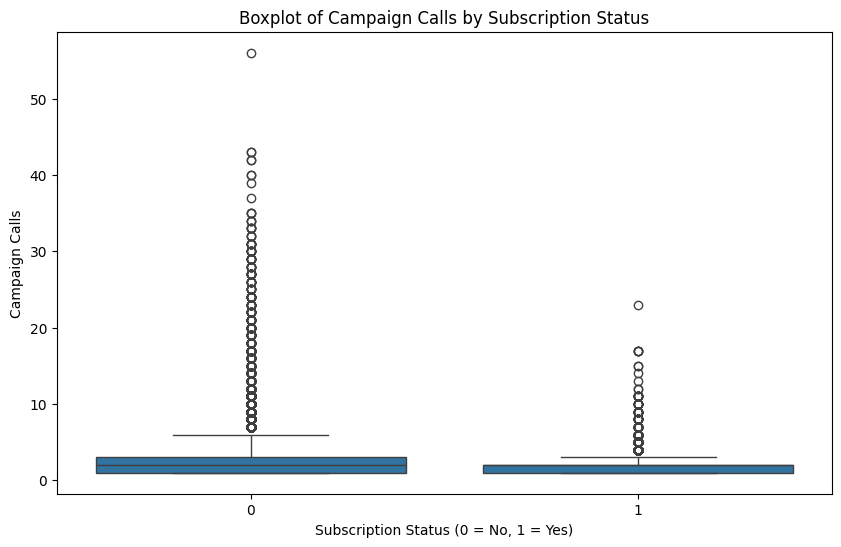

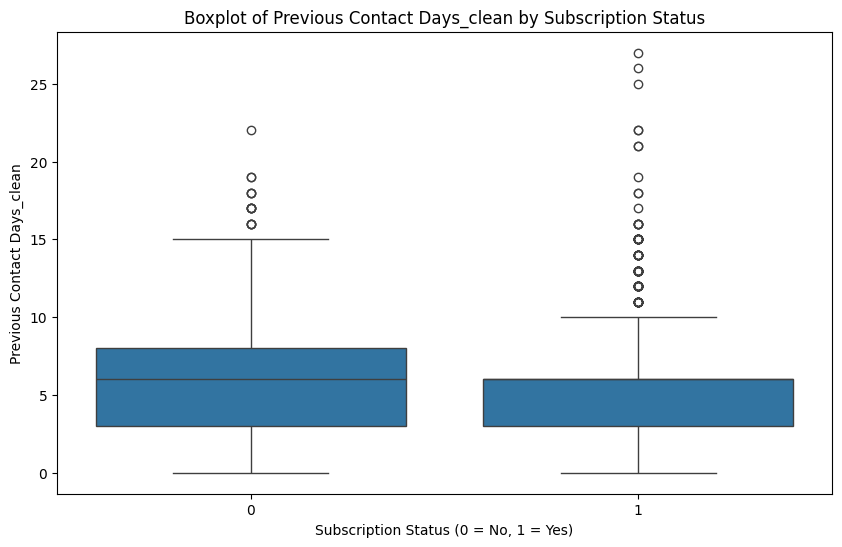

In [84]:
continuous_features = ["Age_numerical", "Campaign Calls", "Previous Contact Days_clean"]
for feature in continuous_features:
    plt.figure(figsize=(10,6))
    sns.boxplot(x='Subscription_Status_Code', y=feature, data=df_cleaned)
    plt.title(f'Boxplot of {feature} by Subscription Status')
    plt.xlabel('Subscription Status (0 = No, 1 = Yes)')
    plt.ylabel(feature)
    plt.show()

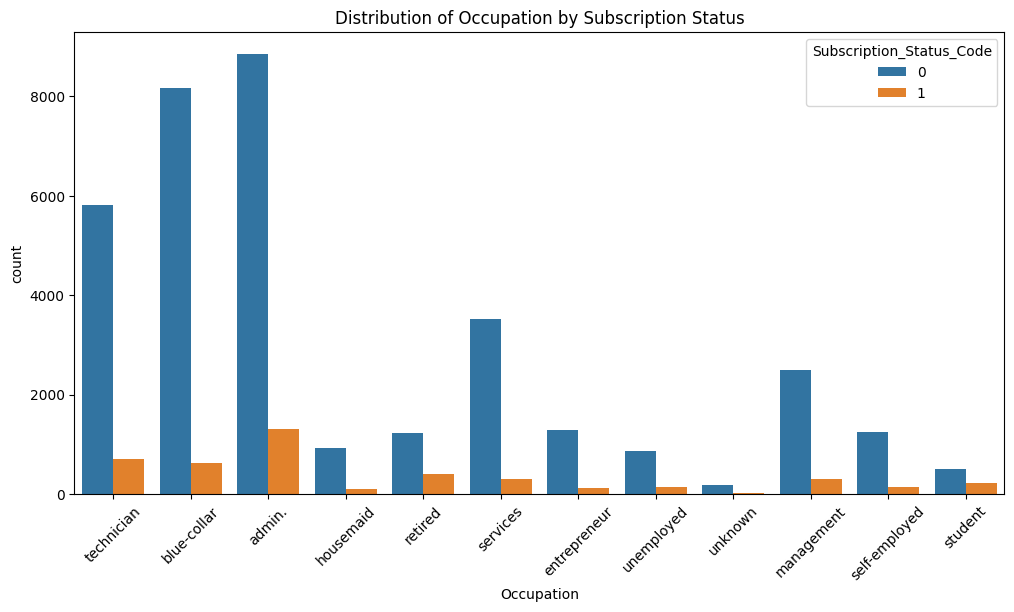

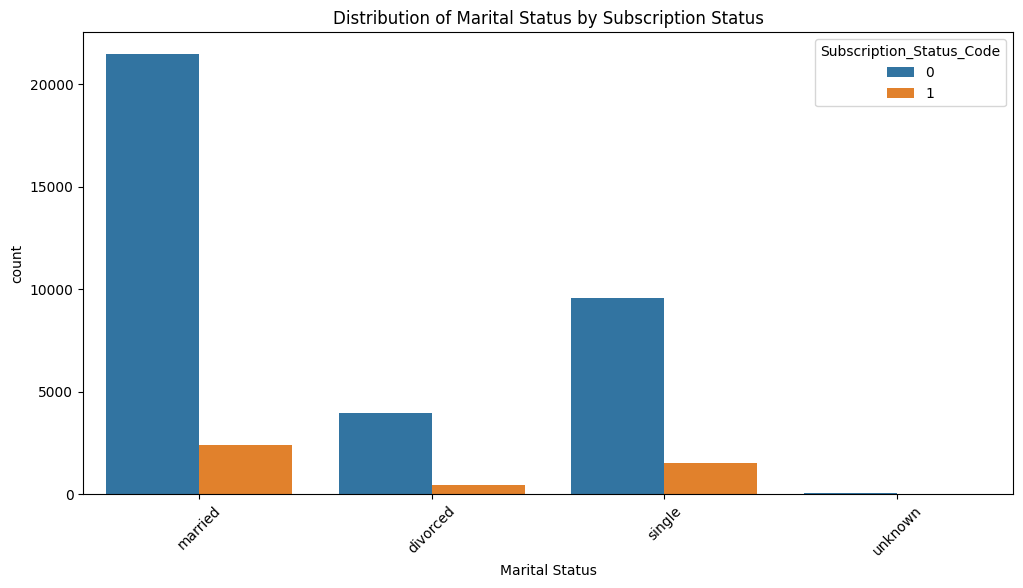

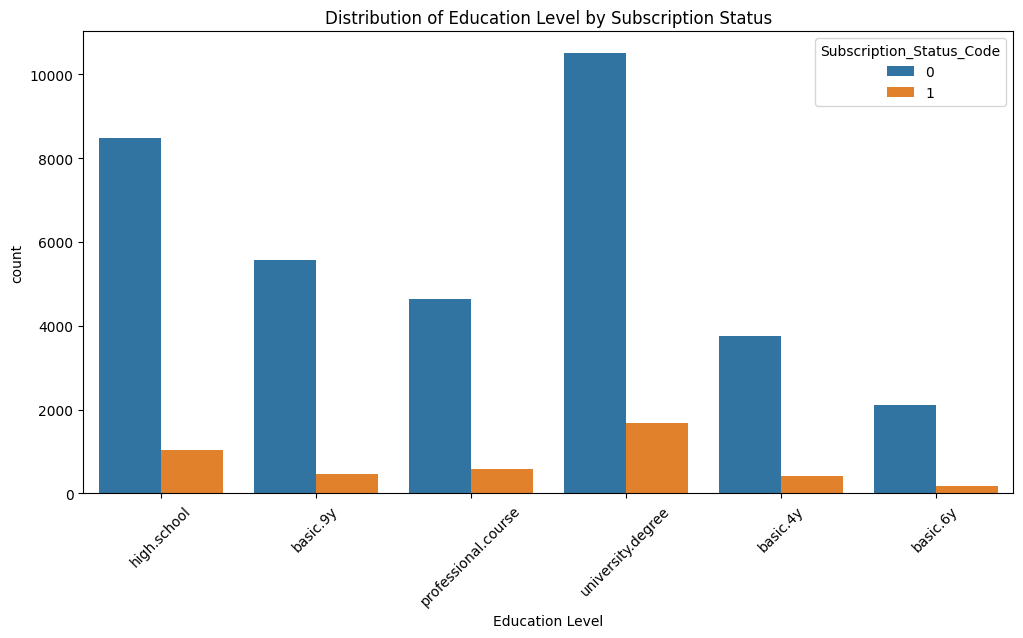

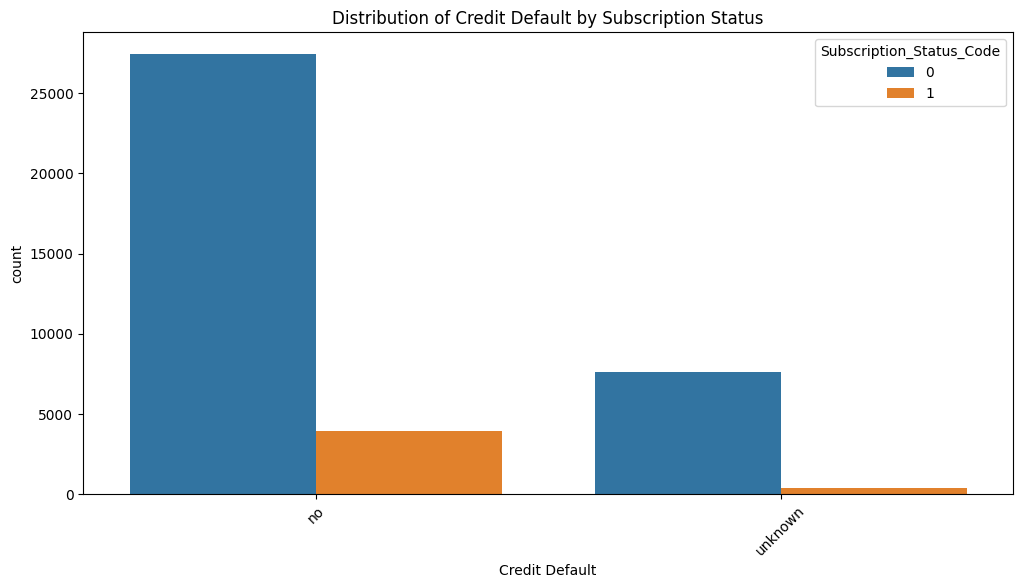

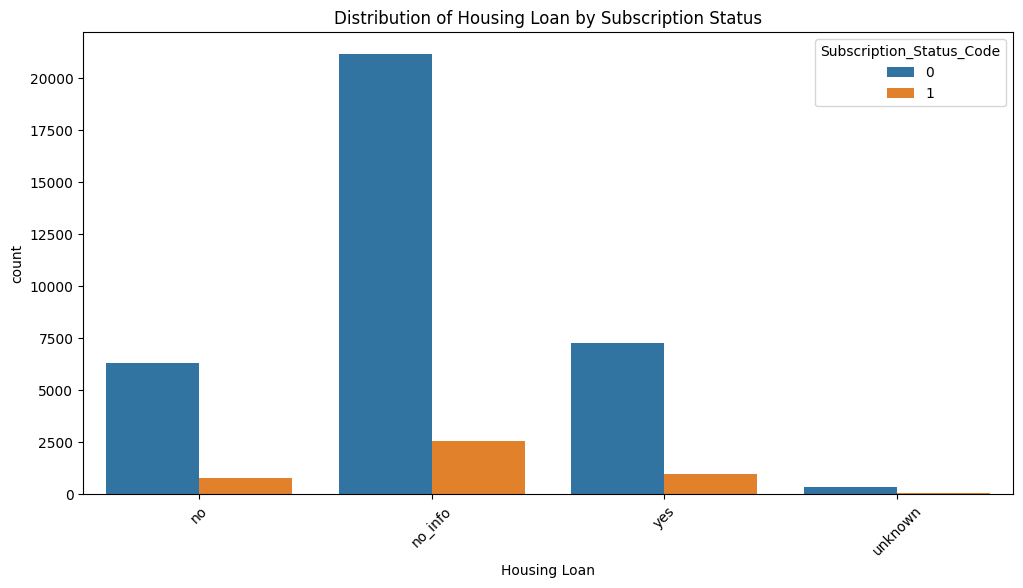

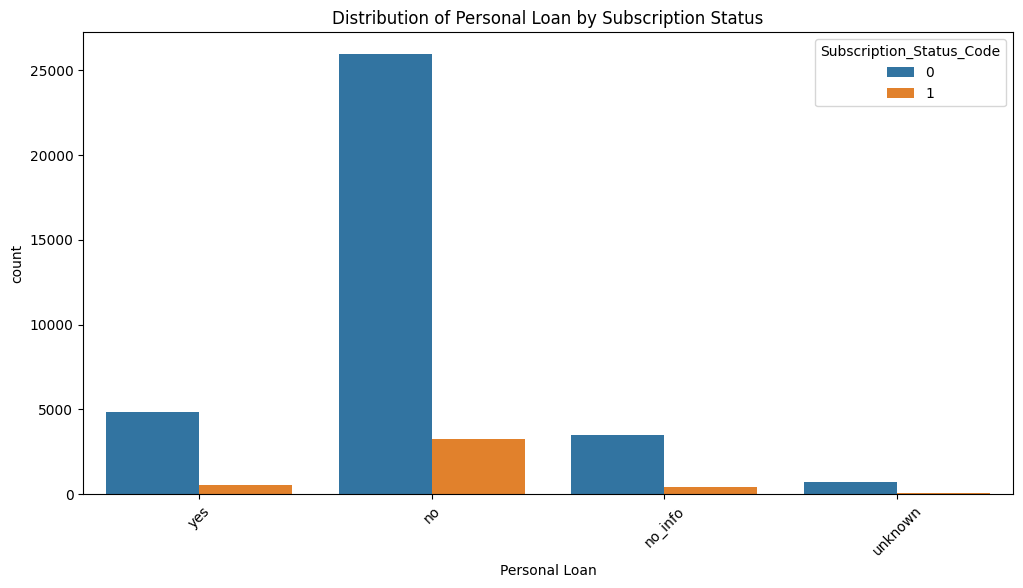

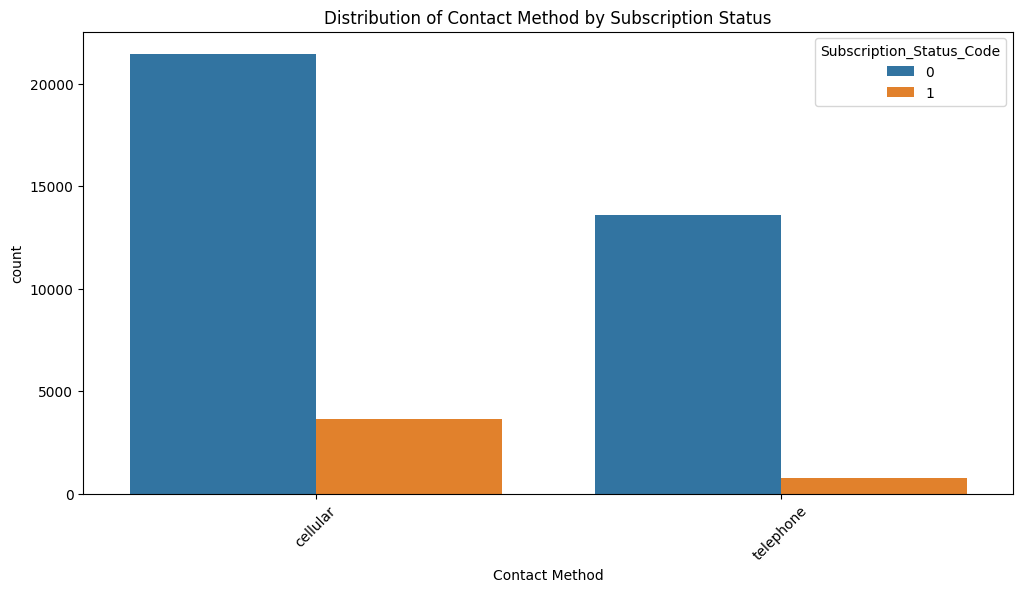

In [63]:
cat_cols = ["Occupation", "Marital Status", "Education Level", "Credit Default", "Housing Loan", "Personal Loan", "Contact Method"]

for col in cat_cols:
    plt.figure(figsize=(12,6))
    sns.countplot(data=df_cleaned, x=col, hue="Subscription_Status_Code")
    plt.title(f"Distribution of {col} by Subscription Status")
    plt.xticks(rotation=45)
    plt.show()

### (5) Feature Engineering

In order to make more meaningful insights, we will engineer some features such as:\
-Job Type Category (Job_Type):\
-Age Grouping (Age_Group):\
-Education Type Category (Education_Rank):\
-Loan Count (Loan_Count):

What is the Job_Type feature and how does it help the project?\
\
Job_Type_Classification helps to group the original detailed occupations into a smaller number of meaningful categories.\
They include:\
White Colllar: Contains people working in administration, management and entrepreneurs.\
Blue Collar: Includes technicians, people who work in the services sector and blue collared workers\
No Active Income: Consists of students, retirees and the unemployed, which are all groups that currently do not have an income, but may still have savings\
Other: Contains unknown cases\
\
White collar roles tend to usually earn more than blue collar roles.\
Positions with a fixed salary are likely to be more financially stable than those who are unemployed or not working.\
People with a higher income are likely to have a higher disposable income and may be more willing to commit their funds into a term deposit, which is a long term product.\
\
This feature helps to decrease the wide spread of data across the many categories found in "Occupation", by combining them into broader but still meaningful groups. This helps to increase the sample count while capturing the general importance of each category, and would lead to more reliable analysis and patterns.

In [64]:
def Job_Type_Classification(job):
    if job in ["admin.", "management", "entrepreneur", "self-employed"]:
        return "White-Collar"
    elif job in ["blue-collar", "technician", "services", "housemaid"]:
        return "Blue-Collar"
    elif job in ["student", "unemployed", "retired"]:
        return "No Active Income"
    else:
        return "Other"
    
df_cleaned["Job_Type"]=df_cleaned["Occupation"].apply(Job_Type_Classification)

What is the Age_Grpup feature and how does it help the project?\
\
Age_group helps to convert the numerical age into bins\
Youth (<= 25 years old)\
Young Adult (26-35 years old)\
Adult (36-50 years old)\
Mature (51-65 years old)\
Senior (>65 years old)\
\
Age is and has always been an extremely popular feature in the financial sector:\
Younger people will generally tend to have lower savings, but they have
This helps to improve the scope of the data and generalize the data into more meaningful variables.\
Also, based on research and other financial datasets I have looked at online, the relationship between age and the subscription is not strictly linear. Hence, binning helps to capture the relationship better by age groups than just singular numeric age values.\
\
This feature helps to reduce noise and captures non-linear patterns better.

In [65]:
bins=[0, 25, 35, 50, 65, 100]
labels=["Youth", "Young Adult", "Adult", "Mature", "Senior"]
df_cleaned["Age_Group"]=pd.cut(df_cleaned["Age_numerical"], bins=bins, labels=labels)

What is the Loan Count feature and how does it help the project?\
\
Loan_Count aggregates the "Housing Loan" and "Personal Loan" into a singular integer, where 0 means no loans, 1 means one of the two loans, and 2 means both housing and personal loans.\
This helps to improve the scope of the data and generalize the data into more meaningful variables.\
\
Customers with 0 loans may have more disposable income and might be more willing to place their money in a term deposit.\
Customers with 1 loan are likely to be in a moderate financial position.\
Customers with 2 loans are likely to have less disposable income and might not be able to afford to place their funds into a term deposit.\
\
This feature helps to combine information from both "Housing Loan" and "Personal Loan", and could reveal patterns that could not be captured seperately in the two columns.

In [66]:
df_cleaned["Loan_Count"]=((df_cleaned["Housing Loan"]=="yes").astype(int) + (df_cleaned["Personal Loan"]=="yes").astype(int))

### (6) Label Encoding
For the final bivariate analysis, we will convert all the meaningful categorial columns into numerical, to improve the visualization.\

In [67]:
for col in ["Job_Type", "Age_Group"]:
    if col not in cat_cols:
        cat_cols.append(col)

In [68]:
df_cleaned[cat_cols].head()

,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Job_Type,Age_Group
0,technician,married,high.school,no,no,yes,cellular,Blue-Collar,Mature
1,blue-collar,married,basic.9y,no,no,no,cellular,Blue-Collar,Young Adult
2,admin.,married,high.school,no,no,no,telephone,White-Collar,Adult
3,housemaid,married,high.school,no,no_info,no,cellular,Blue-Collar,Young Adult
4,retired,married,professional.course,no,no_info,yes,cellular,No Active Income,Mature


In [69]:
for col in cat_cols:
    df_cleaned[col + "_code"]=df_cleaned[col].astype('category').cat.codes

In [70]:
for col in cat_cols:
    print(f"Mapping for {col}:")
    categories = df_cleaned[col].astype('category').cat.categories
    mapping_df = pd.DataFrame({col: categories,
                               col + 'Code': range(len(categories))})
    display(mapping_df)

Mapping for Occupation:


,Occupation,OccupationCode
0,admin.,0
1,blue-collar,1
2,entrepreneur,2
3,housemaid,3
4,management,4
5,retired,5
6,self-employed,6
7,services,7
8,student,8
9,technician,9


Mapping for Marital Status:


,Marital Status,Marital StatusCode
0,divorced,0
1,married,1
2,single,2
3,unknown,3


Mapping for Education Level:


,Education Level,Education LevelCode
0,basic.4y,0
1,basic.6y,1
2,basic.9y,2
3,high.school,3
4,professional.course,4
5,university.degree,5


Mapping for Credit Default:


,Credit Default,Credit DefaultCode
0,no,0
1,unknown,1


Mapping for Housing Loan:


,Housing Loan,Housing LoanCode
0,no,0
1,no_info,1
2,unknown,2
3,yes,3


Mapping for Personal Loan:


,Personal Loan,Personal LoanCode
0,no,0
1,no_info,1
2,unknown,2
3,yes,3


Mapping for Contact Method:


,Contact Method,Contact MethodCode
0,cellular,0
1,telephone,1


Mapping for Job_Type:


,Job_Type,Job_TypeCode
0,Blue-Collar,0
1,No Active Income,1
2,Other,2
3,White-Collar,3


Mapping for Age_Group:


,Age_Group,Age_GroupCode
0,Youth,0
1,Young Adult,1
2,Adult,2
3,Mature,3
4,Senior,4


In [71]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39436 entries, 0 to 39435
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Client ID                    39436 non-null  int64   
 1   Occupation                   39436 non-null  object  
 2   Marital Status               39436 non-null  object  
 3   Education Level              39436 non-null  object  
 4   Credit Default               39436 non-null  object  
 5   Housing Loan                 39436 non-null  object  
 6   Personal Loan                39436 non-null  object  
 7   Contact Method               39436 non-null  object  
 8   Campaign Calls               39436 non-null  int64   
 9   Subscription Status          39436 non-null  object  
 10  Age_numerical                39436 non-null  int64   
 11  Age_Invalid                  39436 non-null  int64   
 12  Calls_Invalid                39436 non-null  int64   
 13  n

Final bivariate Analysis takeaways\
\
There are no features with high linearity, although it may appear that there are some. However, these

<Axes: >

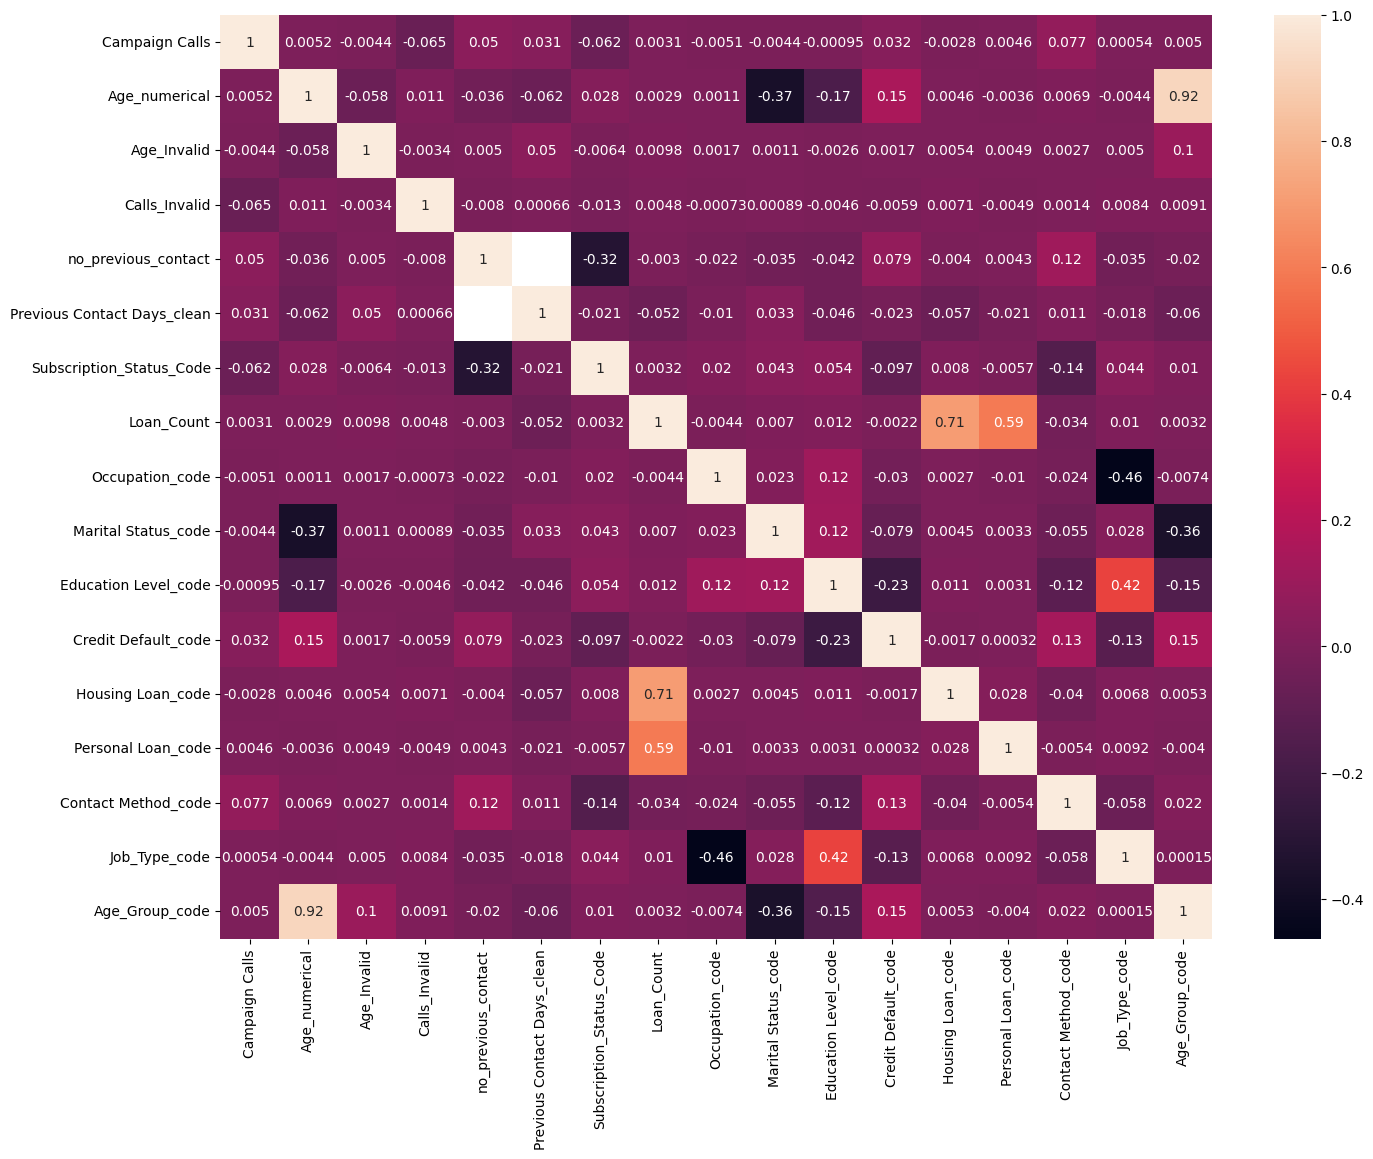

In [72]:
numeric_cols= df_cleaned.select_dtypes(include=['number']).columns

numeric_cols= numeric_cols.drop(['Client ID'])

plt.figure(figsize=(16,12))
sns.heatmap(df_cleaned[numeric_cols].corr(numeric_only=True), annot=True)

### Important Insights from the charts
We can make a few important insights from the charts below, especially based on these few classes:\
\
no_previous_contact ("0" category): For people who were previously contacted, there was a significantly higher chance of them subscribing to the term deposit, with a percentage of 63%. This could point to the fact that having contact could boost or already signify the fact that the client already has a strong interest and wants to gather more information on the terms and conditions of the term deposit.\
\
Contact Method ("cellular" category): Clients who were last contacted with through cellular, had a slightly higher subscription rate of 14% compare to 4% by those contacted throguh telephone.\
\
Age_Group ("Senior" category) & Age_numerical ("" category): Looking at the Age_Group chart, we can see that there is a generally trend of Seniors (>65 age) having a higher subscription rate of over 40% and is double of the next highest category whih is the Youth.\
\
Job_Type ("No Active Income" category) & Occupation ("student", "retired", "unemployed" category): Generally, the graphs show how people with no active income are having a higher subscription rate that is about twice the amount of other job types. Looking deeper into the specific occupations, we can see how students have the highest rate followed by the retired and the unemployed.\

C:\Users\andre\AppData\Local\Temp\ipykernel_6992\3330271424.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_sub= df_cleaned.groupby("Age_Group")["Subscription_Status_Code"].mean().sort_values(ascending=False)


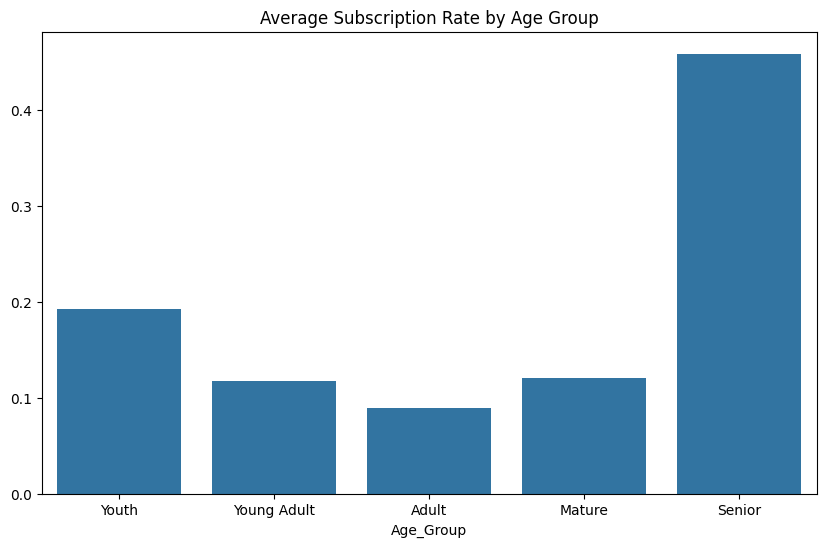

In [73]:
age_group_sub= df_cleaned.groupby("Age_Group")["Subscription_Status_Code"].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=age_group_sub.index, y=age_group_sub.values)
plt.title("Average Subscription Rate by Age Group")
plt.show()

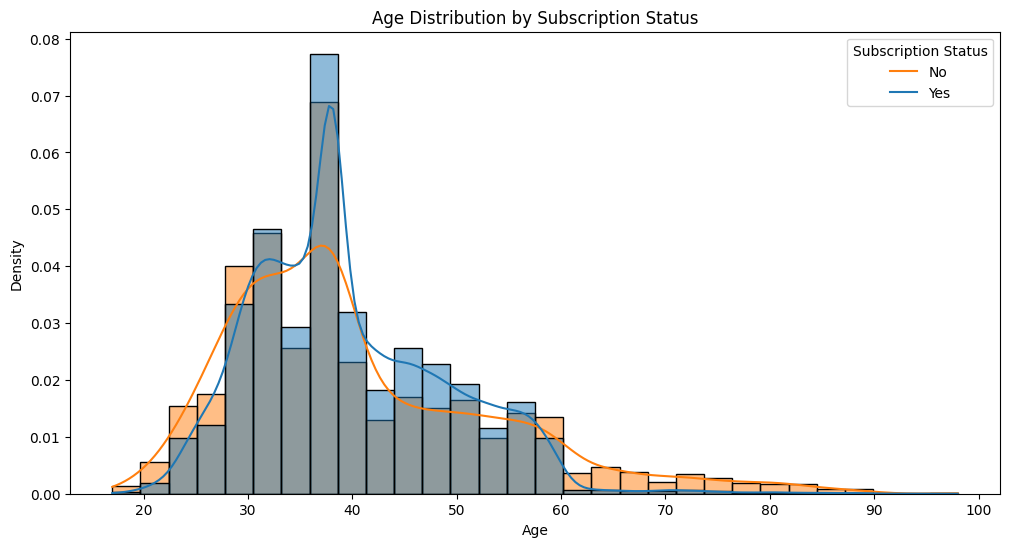

In [74]:
plt.figure(figsize=(12,6))
sns.histplot(data=df_cleaned, x="Age_numerical", hue="Subscription_Status_Code", bins=30, kde=True, stat="density", common_norm=False)
plt.title("Age Distribution by Subscription Status")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend(title="Subscription Status", labels=["No", "Yes"])
plt.show()

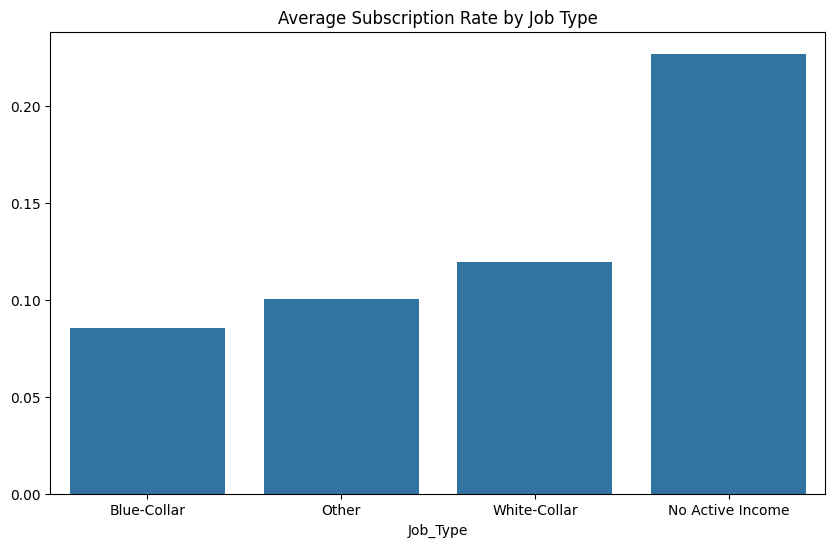

In [75]:
job_type_sub= df_cleaned.groupby("Job_Type")["Subscription_Status_Code"].mean().sort_values()

plt.figure(figsize=(10,6))
sns.barplot(x=job_type_sub.index, y=job_type_sub.values)
plt.title("Average Subscription Rate by Job Type")
plt.show()

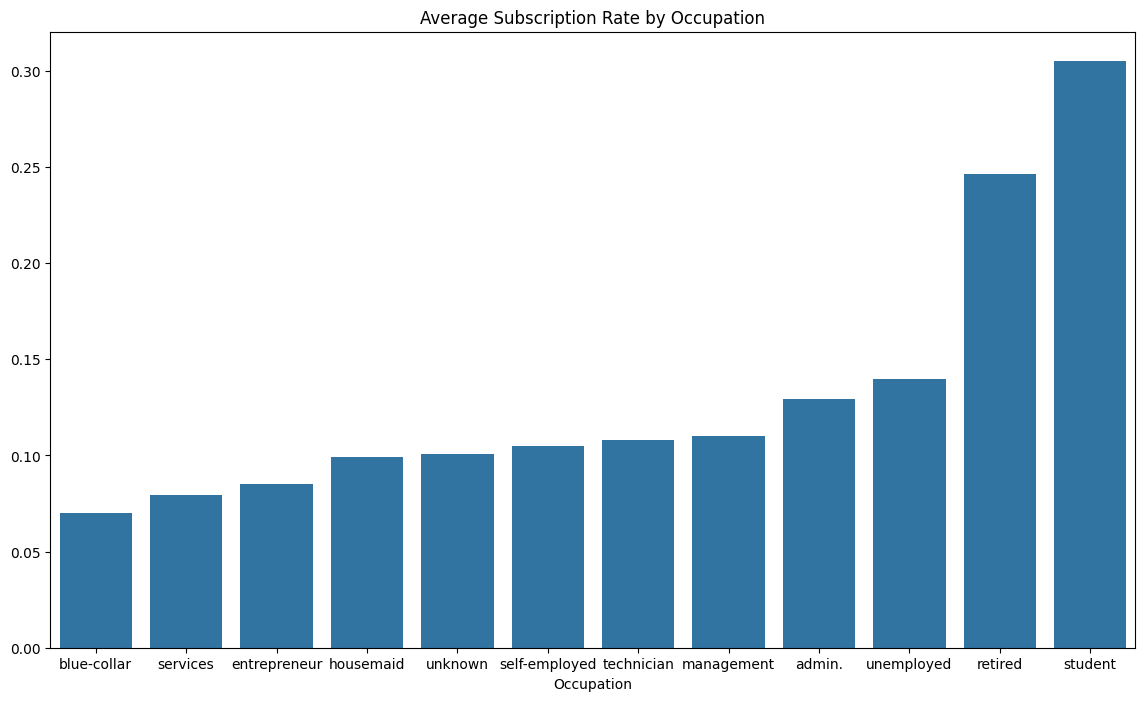

In [76]:
occupation_sub= df_cleaned.groupby("Occupation")["Subscription_Status_Code"].mean().sort_values()
plt.figure(figsize=(14,8))
sns.barplot(x=occupation_sub.index, y=occupation_sub.values)
plt.title("Average Subscription Rate by Occupation")
plt.show()

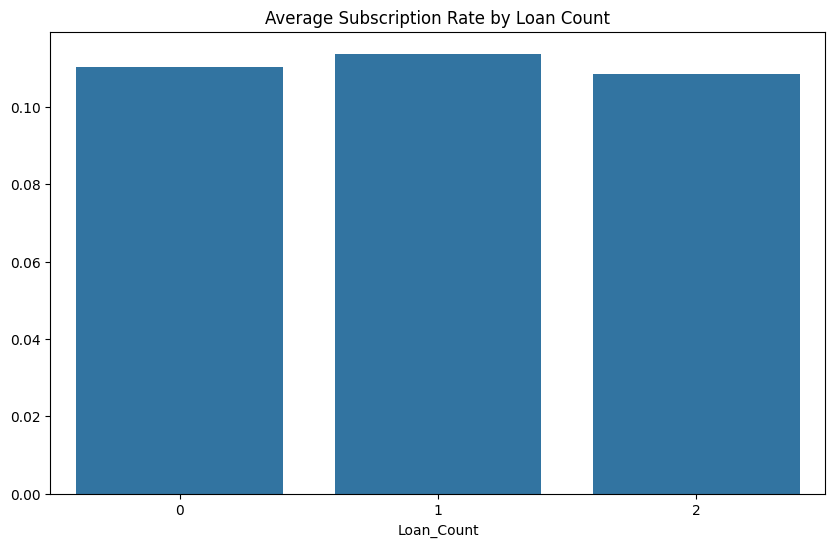

In [77]:
loan_count_sub= df_cleaned.groupby("Loan_Count")["Subscription_Status_Code"].mean().sort_values()

plt.figure(figsize=(10,6))
sns.barplot(x=loan_count_sub.index, y=loan_count_sub.values)
plt.title("Average Subscription Rate by Loan Count")
plt.show()

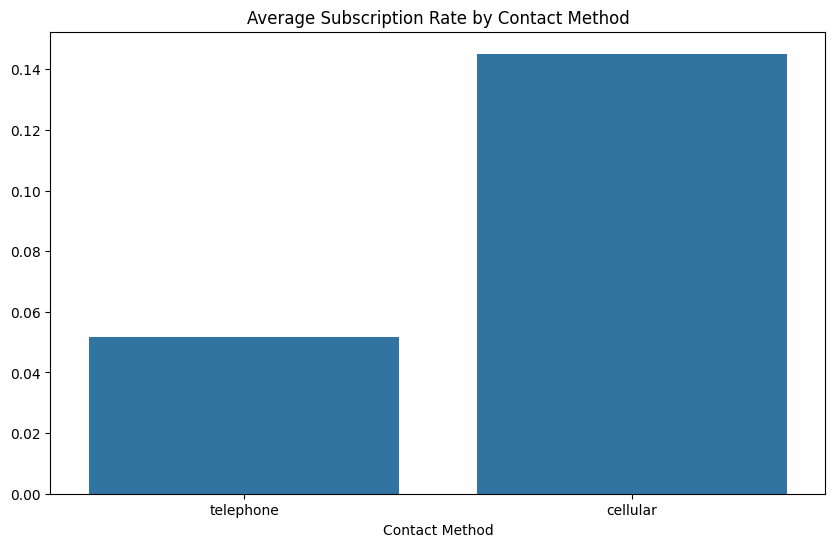

In [78]:
contact_method_sub= df_cleaned.groupby("Contact Method")["Subscription_Status_Code"].mean().sort_values()
plt.figure(figsize=(10,6))
sns.barplot(x=contact_method_sub.index, y=contact_method_sub.values)
plt.title("Average Subscription Rate by Contact Method")
plt.show()

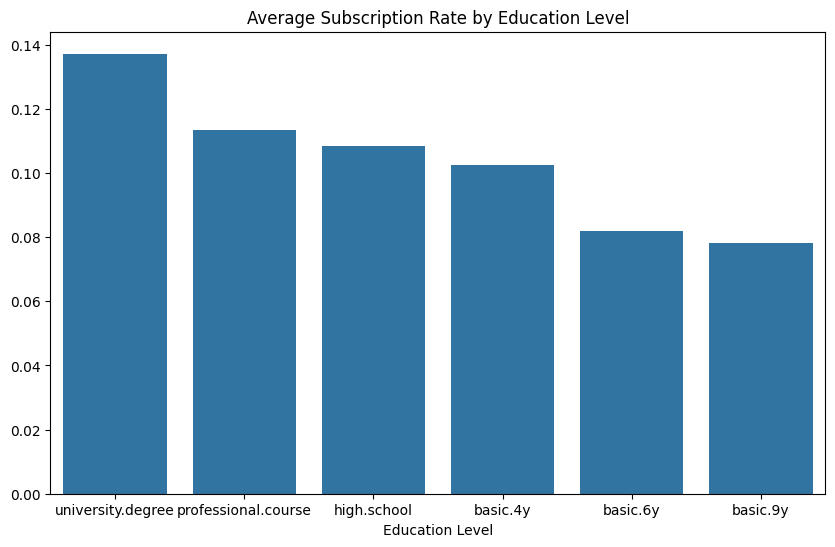

In [79]:
education_level_sub= df_cleaned.groupby("Education Level")["Subscription_Status_Code"].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=education_level_sub.index, y=education_level_sub.values)
plt.title("Average Subscription Rate by Education Level")
plt.show()

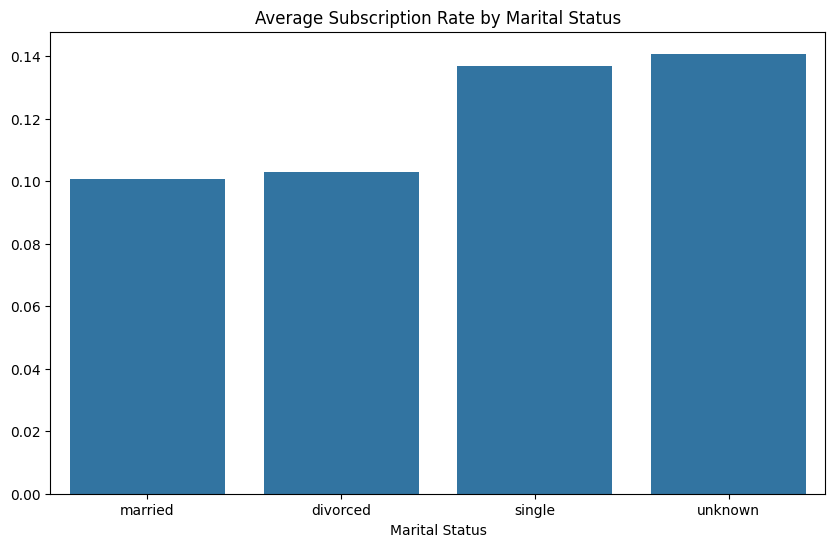

In [80]:
marital_status_sub= df_cleaned.groupby("Marital Status")["Subscription_Status_Code"].mean().sort_values()
plt.figure(figsize=(10,6))
sns.barplot(x=marital_status_sub.index, y=marital_status_sub.values)
plt.title("Average Subscription Rate by Marital Status")
plt.show()

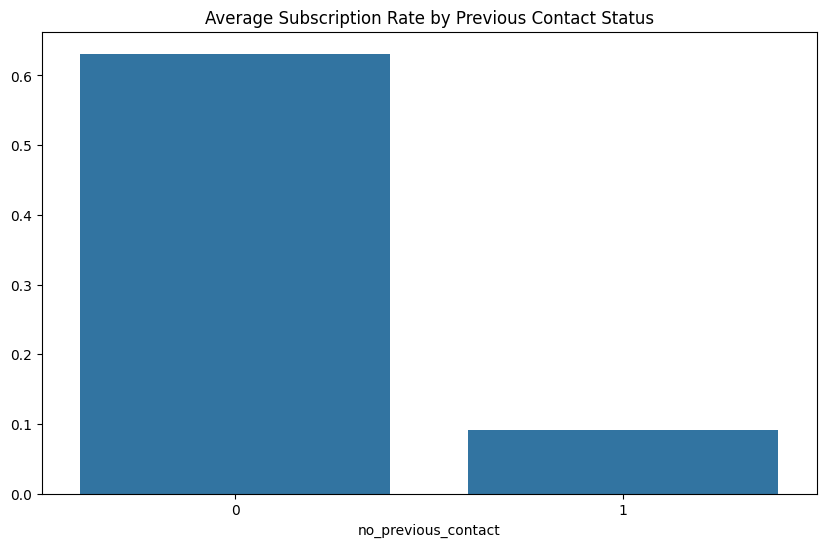

In [81]:
prev_contact_sub= df_cleaned.groupby("no_previous_contact")["Subscription_Status_Code"].mean().sort_values()
plt.figure(figsize=(10,6))
sns.barplot(x=prev_contact_sub.index, y=prev_contact_sub.values)
plt.title("Average Subscription Rate by Previous Contact Status")
plt.show()

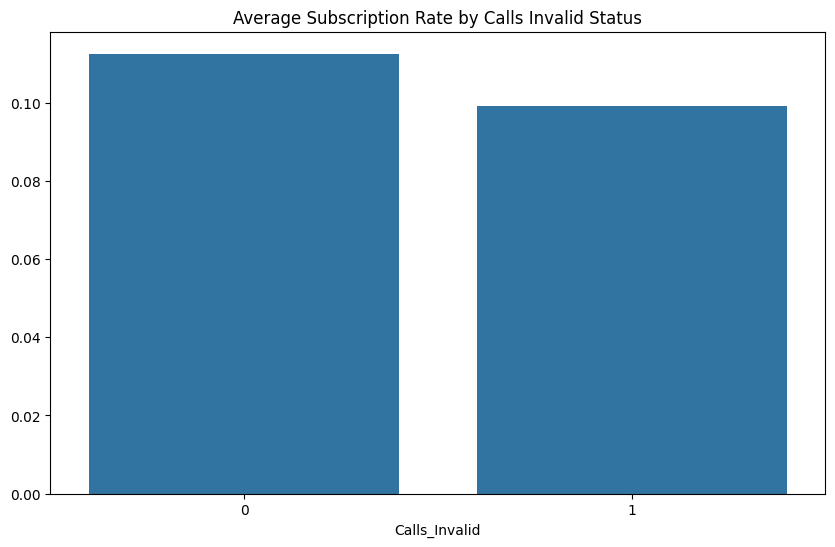

In [82]:
calls_invalid_sub= df_cleaned.groupby("Calls_Invalid")["Subscription_Status_Code"].mean().sort_values()
plt.figure(figsize=(10,6))
sns.barplot(x=calls_invalid_sub.index, y=calls_invalid_sub.values)
plt.title("Average Subscription Rate by Calls Invalid Status")
plt.show()

### (7) Key Insights Summary
Based on the exploratory data analysis conducted on this bank marketing dataset, we have observed many important patterns based on the clients' behaviours and different demographics. These insights we have concluded, can definitely help the bank refine their future marketing strategies, as well as which customer segments have high potential to be subscribers to the term deposits.

1. The overall subscription rate is very low\
-Only ~11% of the clients subscribed to the term deposit.\
-The dataset is extremely imbalanced, with almost 9/10 clients not going through with the subscription.\
-This could suggest how the mass-marketing approaches done by the company are not efficient and are expensive .

2. Having a previous contact histroy significantly boosts subscription likelihood\
-Clients who had been previously contacted showed a ~63% subscription rate, which is very good.\
-Extremely different from first-time contacts which constitutes to ~9 of the subscription rate.\
-This has been shoown to be the predictor with the highest impact out of all the features we have analysed.

3. Age-Subscription Trend\
-The subscription rate varies and it resembles a "U" shape, with Seniors having 45% of the distribution and the Youth having 19% out of all the people who subscribed.\
-This shows how seniors show the highest interest. Followed by the Youth and then the Young Adults and Mature clients.\
-The Adult age group has the lowest subscribtion rate, and this could indicate possible financial commitments such as saving money to buy a house, or paying off their car, or even raising a family.\
-Hence, this U-shaped pattern helps to highlight that the youngest and oldest age groups are the most receptive and responsive to the term deposit offer

4. Job type influences the subscription rate\
-No Active Income clients have a higher subscription rate than the rest, at ~23%.\
-This also aligns with the Age Group results as seniors and students are more likely to subscribe.\
-White-collar clients have a higher subscription rate than blue-collar clients.\
-This could suggest how financial stability and the current available savings can contribute to the client's decision to subscribe.

5. Contact method's effect on subscription rates\
-Although not extreme, cellular methods of contacting the clients have shown to perform better than the traditional telephone method.\
-Moving forward, a digital-first method will likely prove to be a more viable strategy.

6. Education Level scales with subscription rates\
-There is a general trend that the higher the education level of a client, the more likely it is for the client to subscribe to the term deposit. This shows that there is a linear relationship between the two features.\
-This in fact proves how the higher the education level, the more knowledge the client has about finances and they tend to be more financially literate.

7. Loan Count and Marital Status are not major factors in influencing the client's decision\
-We have observed how the number of loans and the marital status of the client do not have a noticable effect on whether the client decides to subscribe or not.
